In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import math
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

plt.style.use('fivethirtyeight')


In [2]:
df = pd.read_csv(r'c:\Users\HOME\Downloads\data.csv', encoding='unicode_escape')

In [3]:
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
199348,554096,21890,S/6 WOODEN SKITTLES IN COTTON BAG,6,5/22/2011 12:51,3.25,14921.0,United Kingdom
186759,552882,23170,REGENCY TEA PLATE ROSES,48,5/12/2011 10:10,1.45,14646.0,Netherlands
303967,563557,84992,72 SWEETHEART FAIRY CAKE CASES,24,8/17/2011 13:33,0.55,15786.0,United Kingdom
110356,545685,22555,PLASTERS IN TIN STRONGMAN,1,3/6/2011 11:55,1.65,14499.0,United Kingdom
478537,577091,22580,ADVENT CALENDAR GINGHAM SACK,3,11/17/2011 16:29,5.95,16531.0,United Kingdom
535963,581217,79144B,PAINTED LIGHTBULB STAR+ MOON,1,12/8/2011 9:20,0.83,NaN,United Kingdom
451481,575211,84378,SET OF 3 HEART COOKIE CUTTERS,2,11/9/2011 10:39,1.45,17377.0,United Kingdom
378268,569638,20981,12 PENCILS TALL TUBE WOODLAND,12,10/5/2011 12:15,0.85,16140.0,United Kingdom
148358,549235,22970,LONDON BUS COFFEE MUG,6,4/7/2011 11:16,2.55,15530.0,United Kingdom
74427,C542426,85199S,SMALL HANGING IVORY/RED WOOD BIRD,-24,1/28/2011 9:32,0.42,14146.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# Check for missing values in each column
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.shape

(541909, 8)

In [7]:
# Data Preprocessing
df_cleaned = df.dropna(subset=['CustomerID', 'Description'])
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)]
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
df_cleaned['Sales'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']


In [8]:
# Count duplicate rows
duplicate_rows_count = df_cleaned.duplicated().sum()

print(f"The number of duplicate rows is: {duplicate_rows_count}")


The number of duplicate rows is: 5192


In [9]:
# Droping duplicate values
df_cleaned.drop_duplicates(inplace=True)

In [10]:
df_cleaned[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,392692.000000,392692.000000
mean,13.119702,3.125914
std,180.492832,22.241836
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


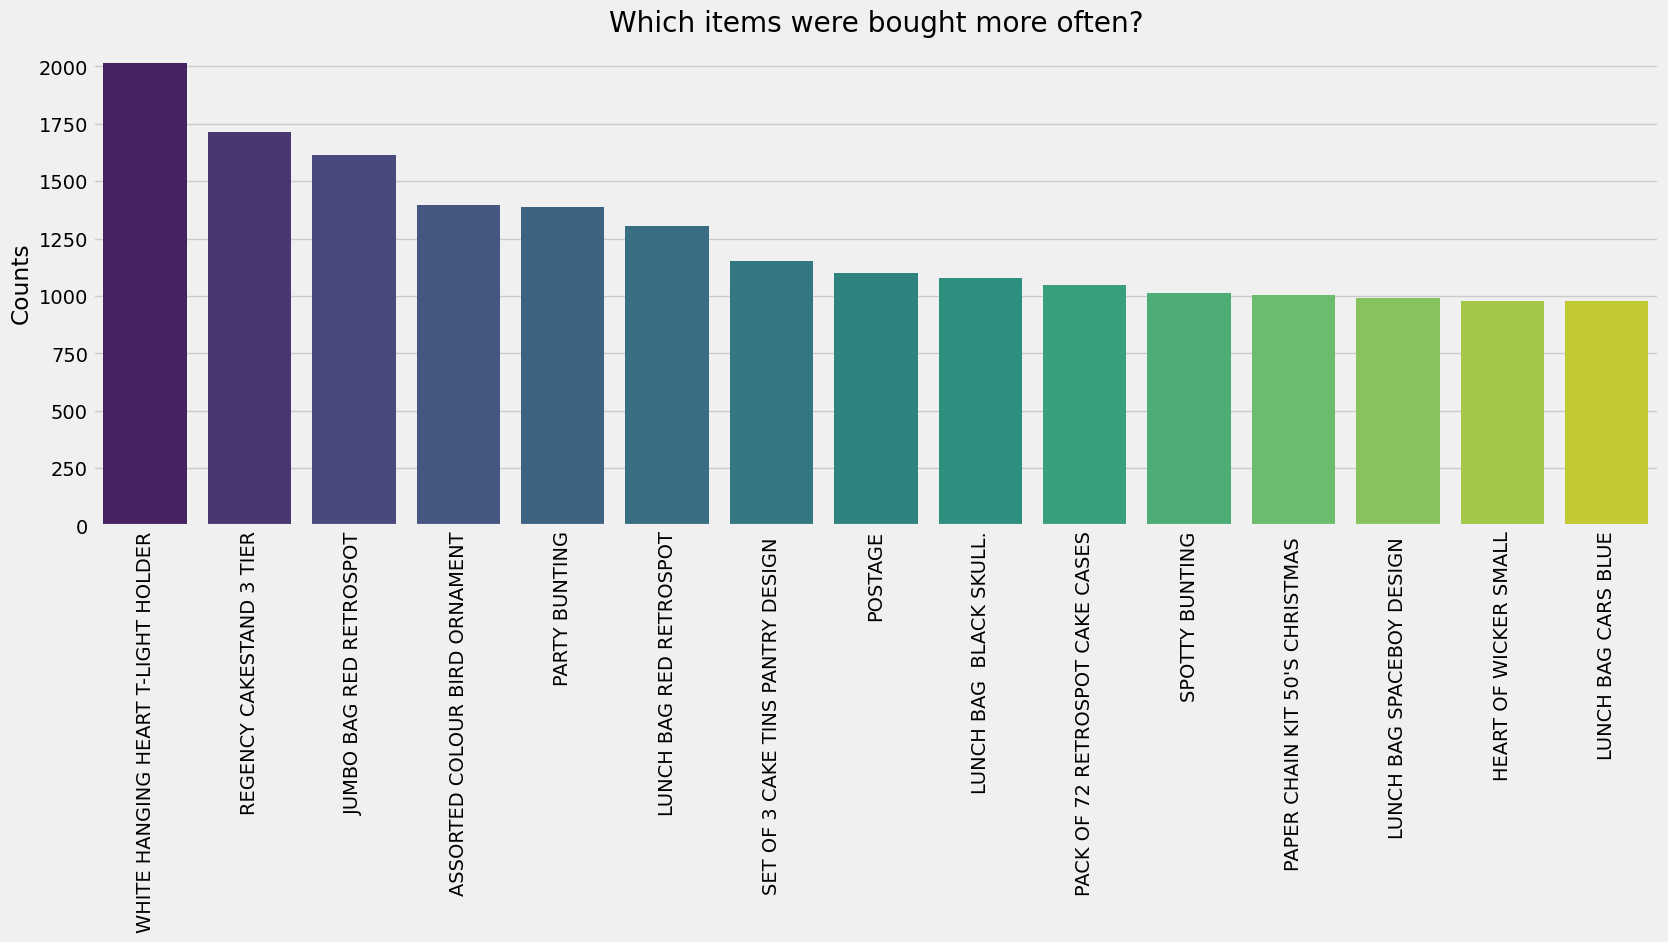

In [11]:
# Description Countplot
item_counts = df_cleaned['Description'].value_counts().sort_values(ascending=False).iloc[0:15]

plt.figure(figsize=(18, 6))
sns.barplot(x=item_counts.index, y=item_counts.values, palette='viridis')  # Change the color palette to 'viridis'
plt.ylabel("Counts")
plt.title("Which items were bought more often?")
plt.xticks(rotation=90)
plt.show()

In [12]:
df_cleaned['Description'].value_counts().nlargest(15)

WHITE HANGING HEART T-LIGHT HOLDER    2016
REGENCY CAKESTAND 3 TIER              1713
JUMBO BAG RED RETROSPOT               1615
ASSORTED COLOUR BIRD ORNAMENT         1395
PARTY BUNTING                         1389
LUNCH BAG RED RETROSPOT               1303
SET OF 3 CAKE TINS PANTRY DESIGN      1152
POSTAGE                               1099
LUNCH BAG  BLACK SKULL.               1078
PACK OF 72 RETROSPOT CAKE CASES       1050
SPOTTY BUNTING                        1014
PAPER CHAIN KIT 50'S CHRISTMAS        1003
LUNCH BAG SPACEBOY DESIGN              993
HEART OF WICKER SMALL                  979
LUNCH BAG CARS BLUE                    977
Name: Description, dtype: int64

In [13]:
df['Description'].value_counts().tail()

Missing                                1
historic computer difference?....se    1
DUSTY PINK CHRISTMAS TREE 30CM         1
WRAP BLUE RUSSIAN FOLKART              1
PINK BERTIE MOBILE PHONE CHARM         1
Name: Description, dtype: int64

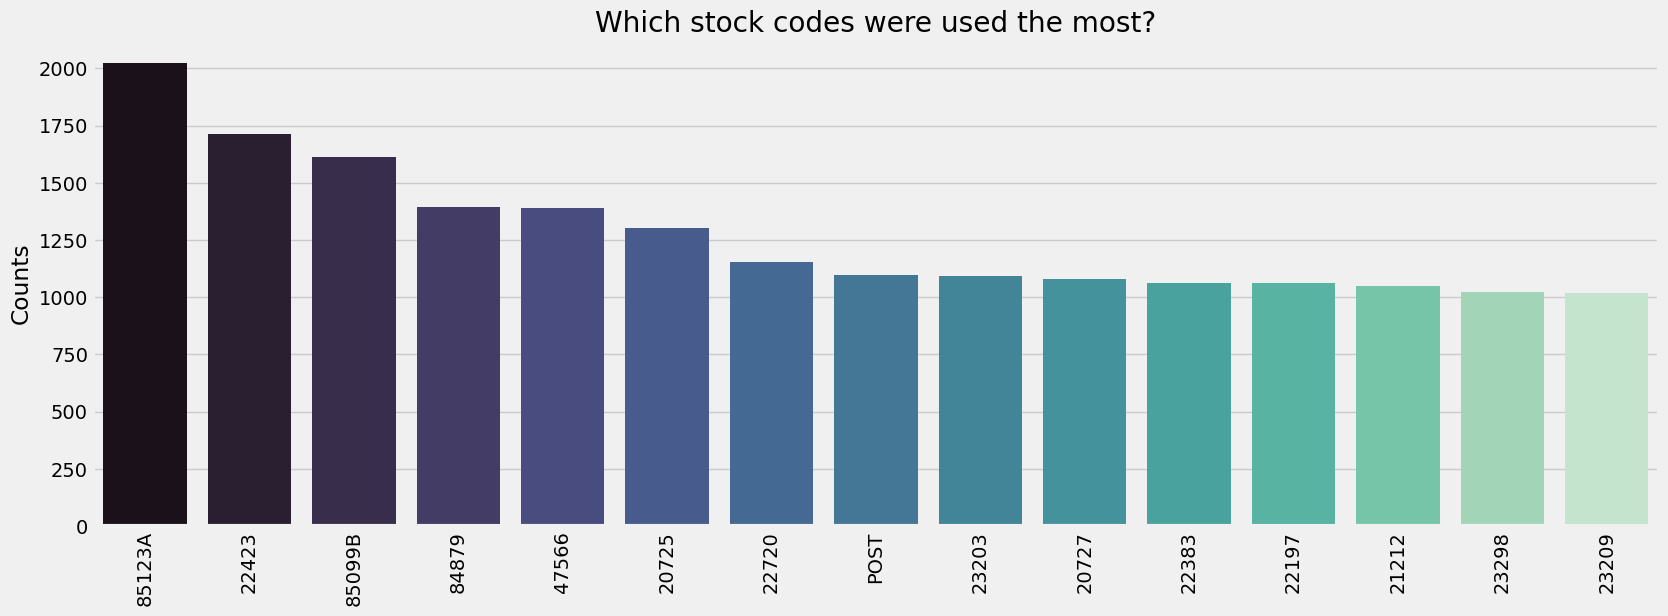

In [14]:
# Stock codes Count plot
stock_counts = df_cleaned['StockCode'].value_counts().sort_values(ascending=False).iloc[0:15]

plt.figure(figsize=(18, 6))
sns.barplot(x=stock_counts.index, y=stock_counts.values, palette='mako')  # Change the color palette to 'YlOrBr'
plt.ylabel("Counts")
plt.title("Which stock codes were used the most?")
plt.xticks(rotation=90)
plt.show()

In [15]:
df_cleaned['StockCode'].value_counts().nlargest(15)

85123A    2023
22423     1713
85099B    1615
84879     1395
47566     1389
20725     1304
22720     1152
POST      1099
23203     1091
20727     1078
22383     1063
22197     1060
21212     1050
23298     1021
23209     1020
Name: StockCode, dtype: int64

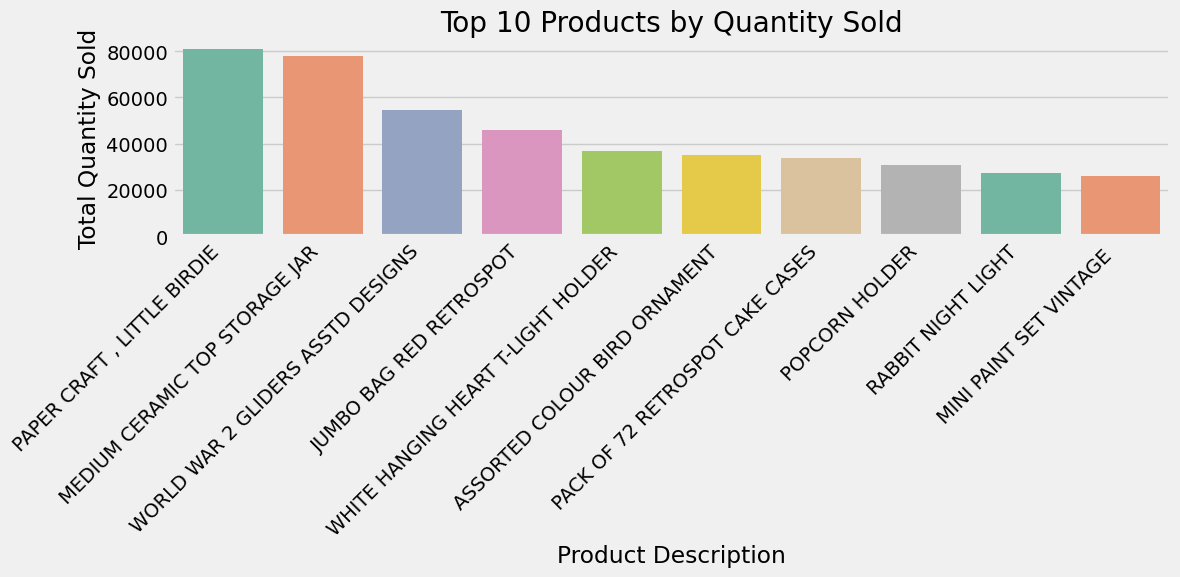

In [16]:
# Calculate the quantity sold for each product
top_products = df_cleaned.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).reset_index()

# Create a bar chart with separate colors using Matplotlib and Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products, x='Description', y='Quantity', palette='Set2')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Product Description')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

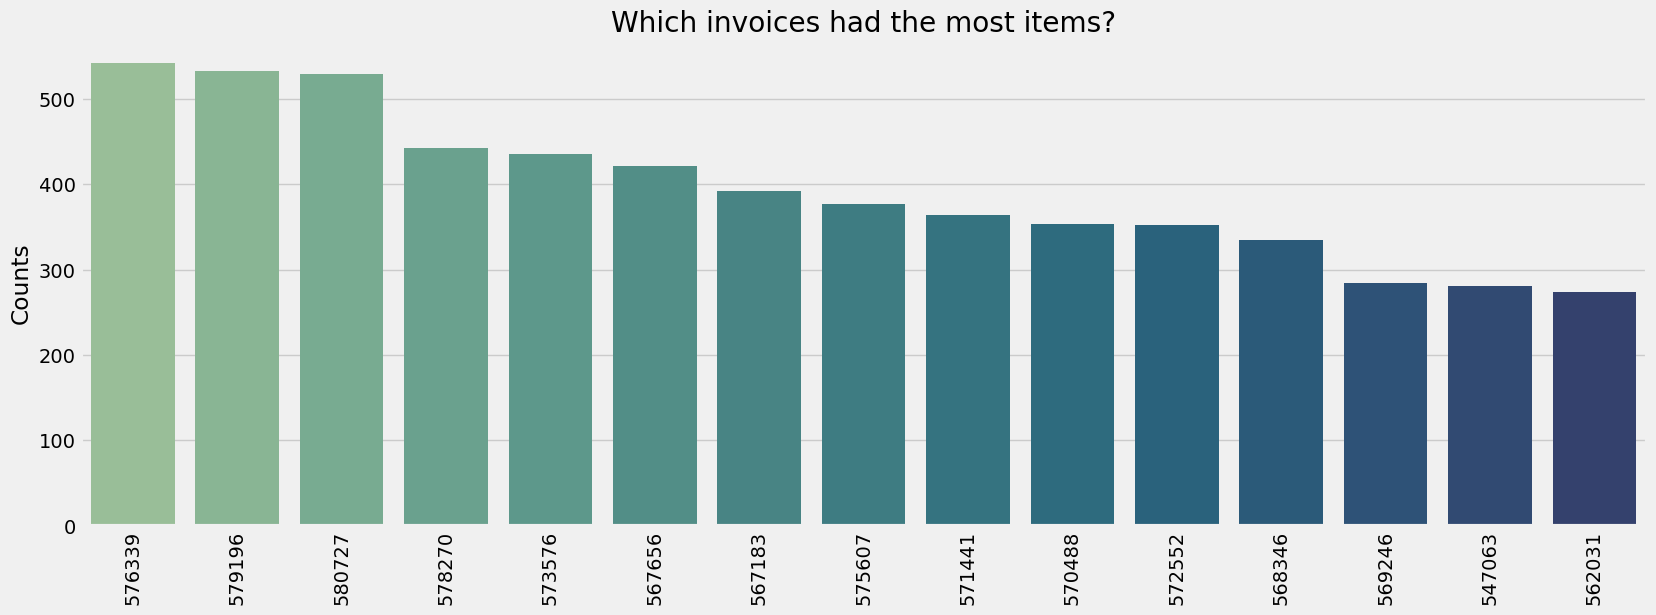

In [17]:
# Invoice with most number of items
inv_counts = df_cleaned['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]

plt.figure(figsize=(18, 6))
sns.barplot(x=inv_counts.index, y=inv_counts.values, palette='crest')  
plt.ylabel("Counts")
plt.title("Which invoices had the most items?")
plt.xticks(rotation=90)
plt.show()

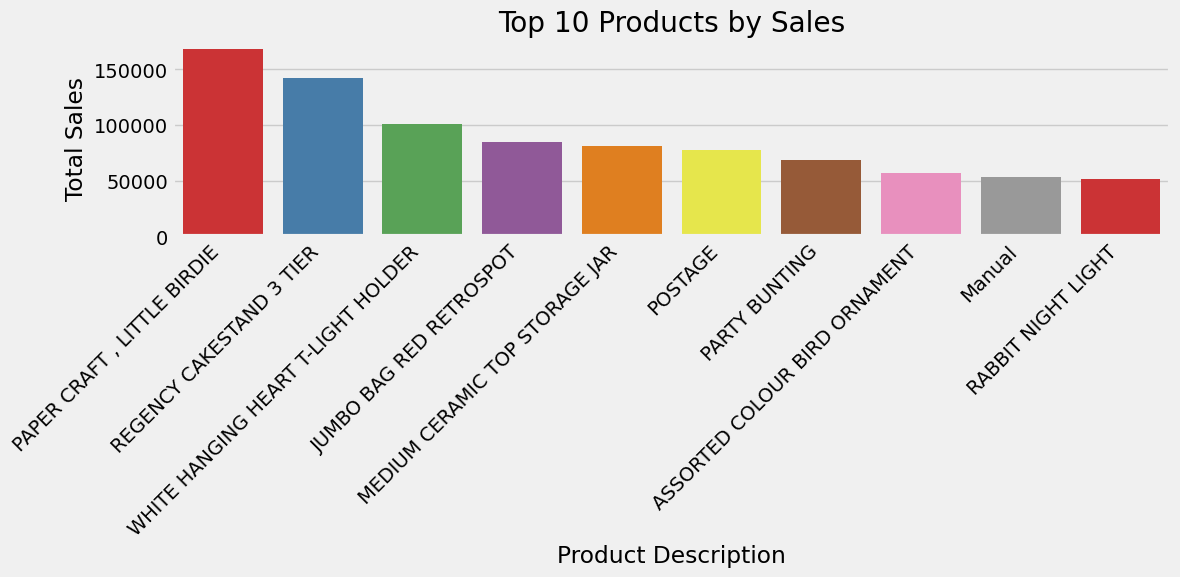

In [18]:
# Group by Description and calculate total sales for each product
product_sales = df_cleaned.groupby('Description')['Sales'].sum().sort_values(ascending=False).head(10).reset_index()

# Bar chart with different colors for each bar using Matplotlib and Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=product_sales, x='Description', y='Sales', palette='Set1')
plt.title('Top 10 Products by Sales')
plt.xlabel('Product Description')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
df_cleaned[df_cleaned['Country'] != "United Kingdom"]['Country'].value_counts().nlargest(10)

Germany        9025
France         8326
EIRE           7226
Spain          2479
Netherlands    2359
Belgium        2031
Switzerland    1841
Portugal       1453
Australia      1181
Norway         1071
Name: Country, dtype: int64

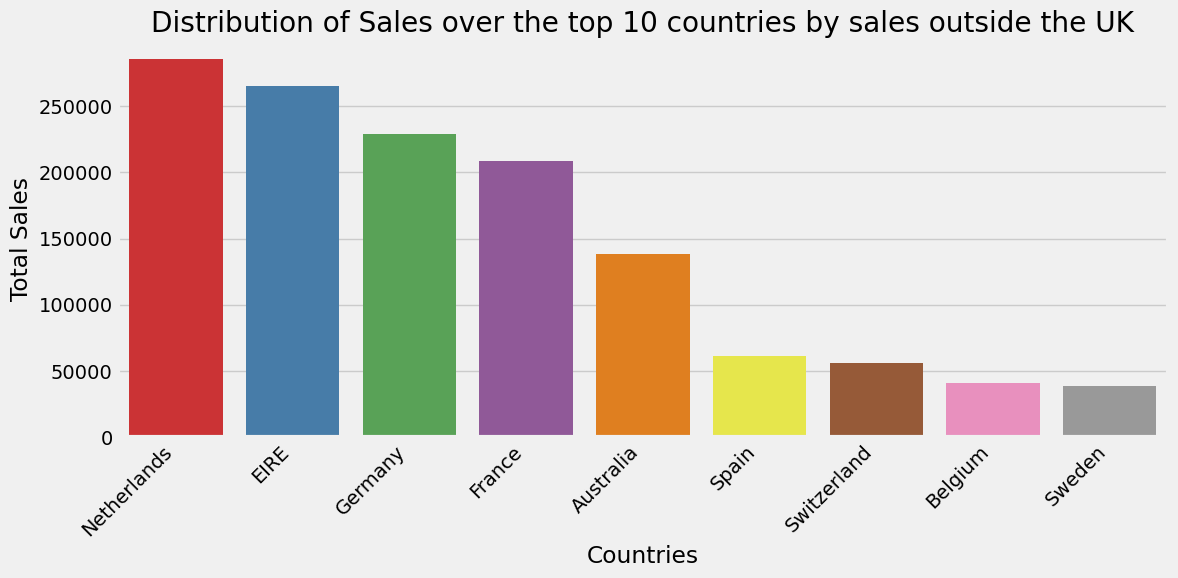

In [20]:
# Group by Countries and calculate total sales for each Country(Excluding United Kingdom)
product_sales_country = df_cleaned.groupby('Country')['Sales'].sum().sort_values(ascending=False).head(10).reset_index()

# Bar chart 
plt.figure(figsize=(12, 6))
sns.barplot(data=product_sales_country[product_sales_country['Country'] != "United Kingdom"], x='Country', y='Sales', palette='Set1')
plt.title("Distribution of Sales over the top 10 countries by sales outside the UK")
plt.xlabel('Countries')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
print("Total Sales for United Kingdom is",df_cleaned[df_cleaned["Country"] == 'United Kingdom']['Sales'].sum().round(2))
print("Total Sales for Other is",df_cleaned[df_cleaned["Country"] != 'United Kingdom']['Sales'].sum().round(2))

Total Sales for United Kingdom is 7285024.64
Total Sales for Other is 1602184.25


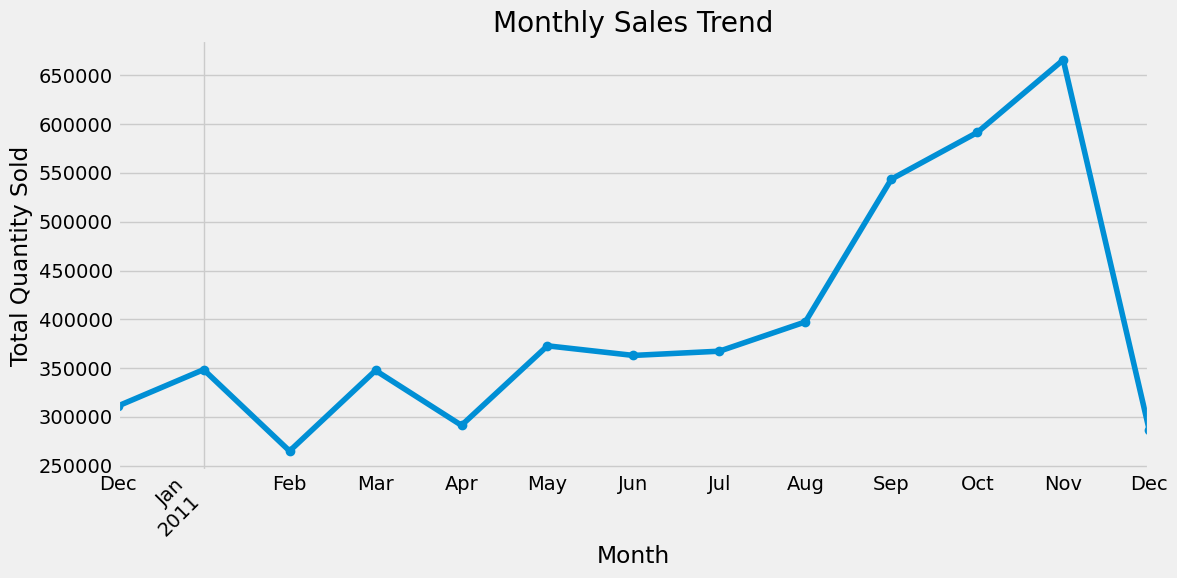

In [22]:
# Monthly sales trend
df1 = df_cleaned.copy()
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])
df1['Month'] = df1['InvoiceDate'].dt.to_period('M')
monthly_sales = df1.groupby('Month')['Quantity'].sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
# Function for outlier removal based on IQR
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    df_outlier_free = df[(df[column_name] >= Q1 - 1.5 * IQR) & (df[column_name] <= Q3 + 1.5 * IQR)]
    return df_outlier_free
# Remove outliers for 'UnitPrice' and 'Quantity'
df_outlier_free_unit_price = remove_outliers(df_cleaned, 'UnitPrice')
df_cleaned = remove_outliers(df_outlier_free_unit_price, 'Quantity')

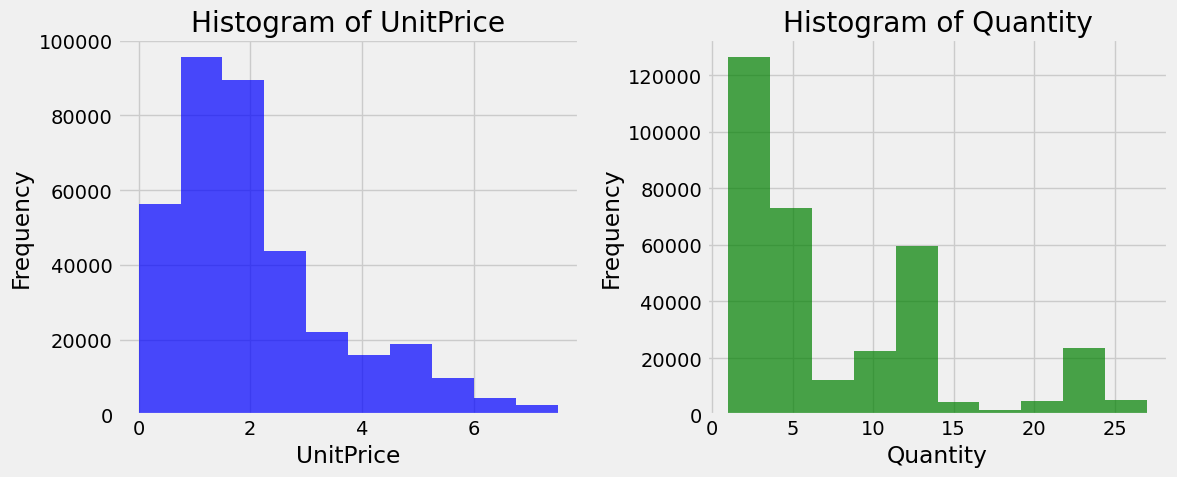

In [24]:
# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_outlier_free_unit_price['UnitPrice'], bins=10, color='blue', alpha=0.7)
plt.title('Histogram of UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_cleaned['Quantity'], bins=10, color='green', alpha=0.7)
plt.title('Histogram of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



In [25]:
# Aggregate Data by Date
df_aggregated = df_cleaned.groupby(pd.Grouper(key='InvoiceDate', freq='D')).agg({'Sales': 'sum'}).reset_index()

Basic Statistics:
count      374.000000
mean     11495.925626
std       7993.486659
min          0.000000
25%       6235.182500
50%      11194.050000
75%      15955.890000
max      37007.320000
Name: Sales, dtype: float64

Missing Values:
InvoiceDate    0
Sales          0
dtype: int64


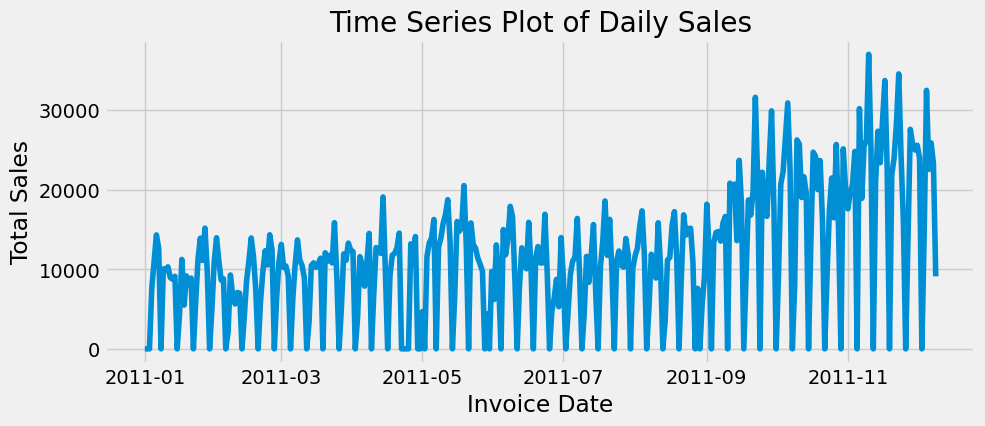

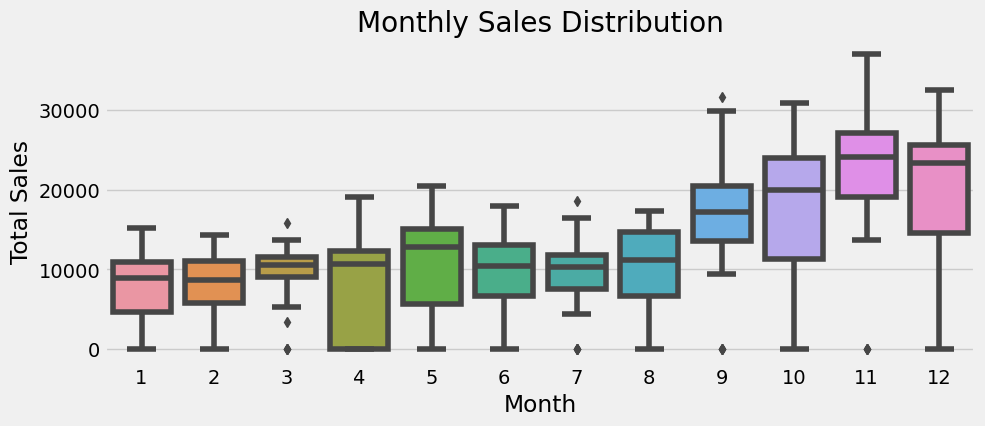

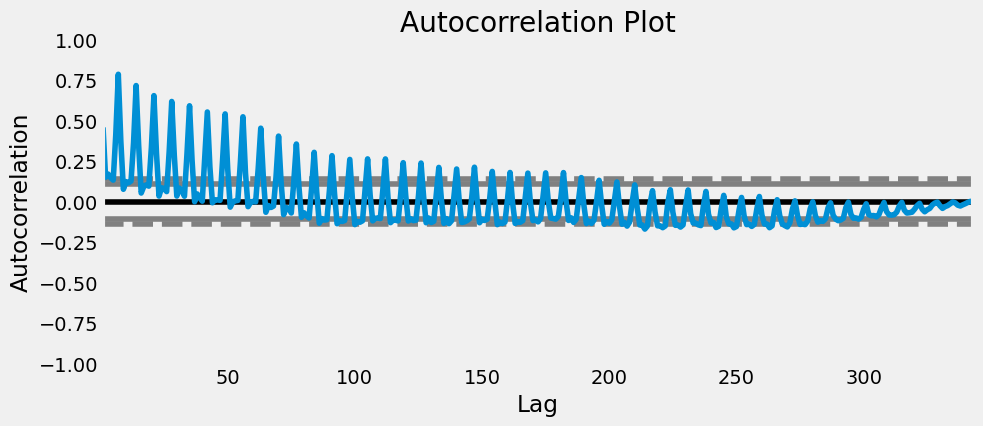

In [26]:

# Basic statistics
print("Basic Statistics:")
print(df_aggregated['Sales'].describe())

# Check for missing values
print("\nMissing Values:")
print(df_aggregated.isnull().sum())

df_filtered = df_aggregated[df_aggregated['InvoiceDate'] > '2010-12-31']

# Time series plot
plt.figure(figsize=(10, 4))
plt.plot(df_filtered['InvoiceDate'], df_filtered['Sales'])
plt.title('Time Series Plot of Daily Sales')
plt.xlabel('Invoice Date')
plt.ylabel('Total Sales')
plt.show()

# Boxplot for seasonality and outliers
plt.figure(figsize=(10, 4))
sns.boxplot(df_filtered['InvoiceDate'].dt.month, df_filtered['Sales'])
plt.title('Monthly Sales Distribution')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

# Autocorrelation plot
plt.figure(figsize=(10, 4))
autocorrelation_plot(df_filtered['Sales'])
plt.title('Autocorrelation Plot')
plt.show()

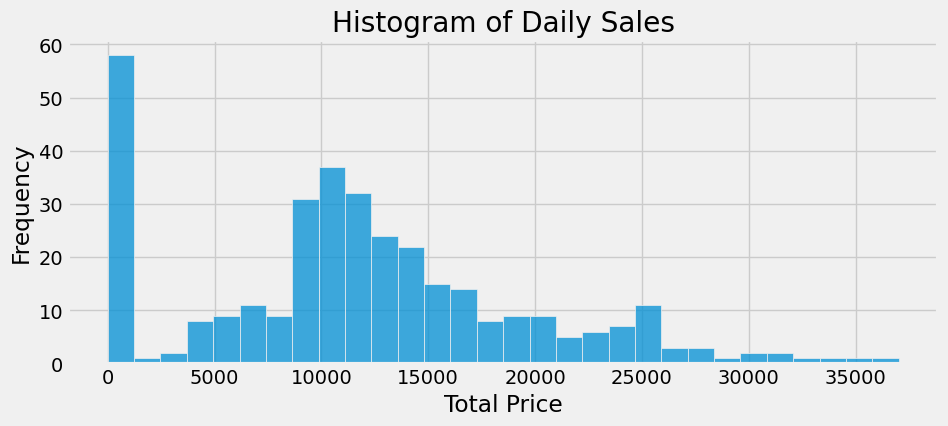

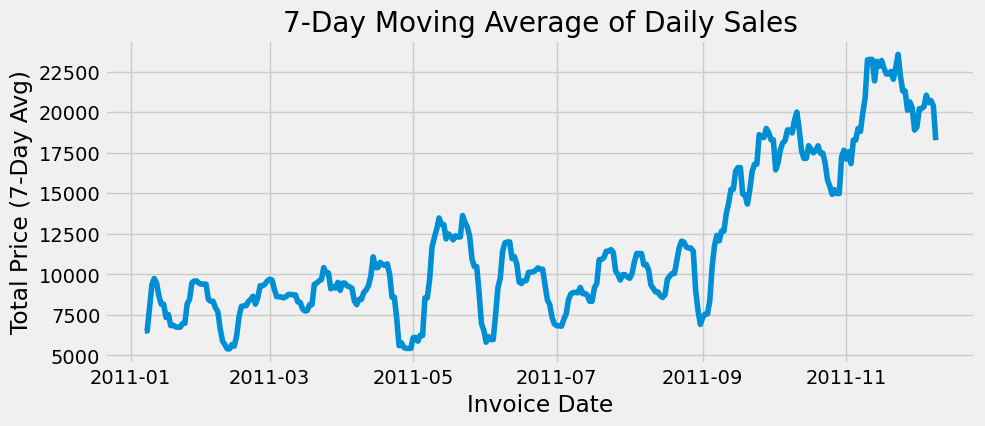

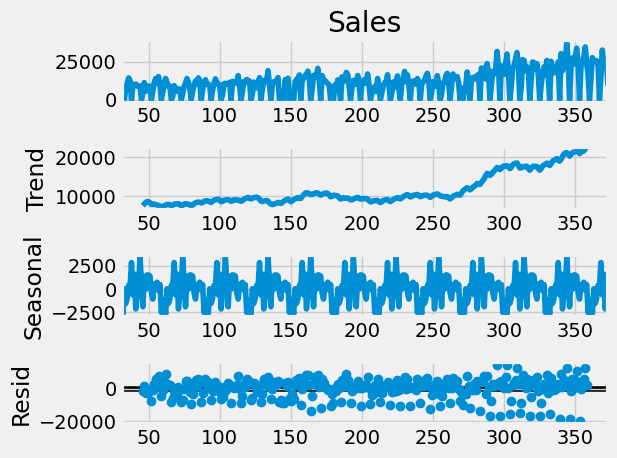

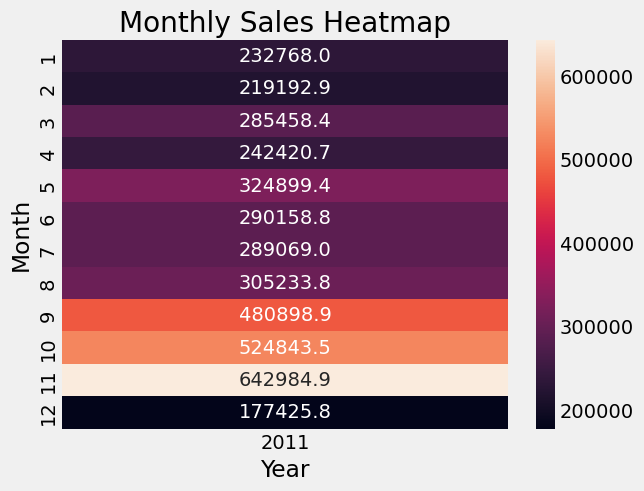

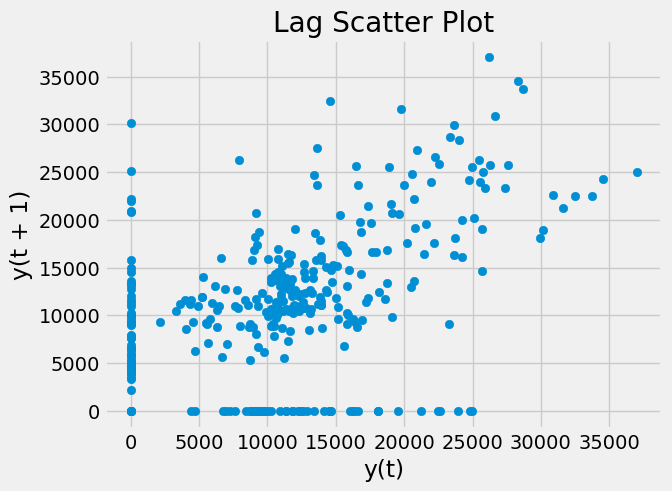

In [27]:
# Histogram
plt.figure(figsize=(10, 4))
sns.histplot(df_filtered['Sales'], bins=30)
plt.title('Histogram of Daily Sales')
plt.xlabel('Total Price')
plt.ylabel('Frequency')
plt.show()

# Moving Average
df_filtered['Moving_Avg'] = df_filtered['Sales'].rolling(window=7).mean()
plt.figure(figsize=(10, 4))
plt.plot(df_filtered['InvoiceDate'], df_filtered['Moving_Avg'])
plt.title('7-Day Moving Average of Daily Sales')
plt.xlabel('Invoice Date')
plt.ylabel('Total Price (7-Day Avg)')
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose
# Seasonal Decomposition
result = seasonal_decompose(df_filtered['Sales'].fillna(0), period=30)  # Monthly seasonality
result.plot()
plt.show()

# Heatmap
df_filtered['Year'] = df_filtered['InvoiceDate'].dt.year
df_filtered['Month'] = df_filtered['InvoiceDate'].dt.month
pivot_table = df_filtered.pivot_table(values='Sales', index='Month', columns='Year', aggfunc='sum')
sns.heatmap(pivot_table, annot=True, fmt=".1f")
plt.title('Monthly Sales Heatmap')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

from pandas.plotting import lag_plot
# Lag Scatter Plot
lag_plot(df_filtered['Sales'])
plt.title('Lag Scatter Plot')
plt.show()

## LSTM


Epoch 1/50
288/288 [==============================] - 3s 3ms/step - loss: 0.0464
Epoch 2/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0262
Epoch 3/50
288/288 [==============================] - 1s 4ms/step - loss: 0.0209
Epoch 4/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0184
Epoch 5/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0174
Epoch 6/50
288/288 [==============================] - 1s 4ms/step - loss: 0.0172
Epoch 7/50
288/288 [==============================] - 1s 4ms/step - loss: 0.0169
Epoch 8/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0168
Epoch 9/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0166
Epoch 10/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0165
Epoch 11/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0166
Epoch 12/50
288/288 [==============================] - 1s 4ms/step - loss: 0.0165
Epoch 13/50
288/288 [====

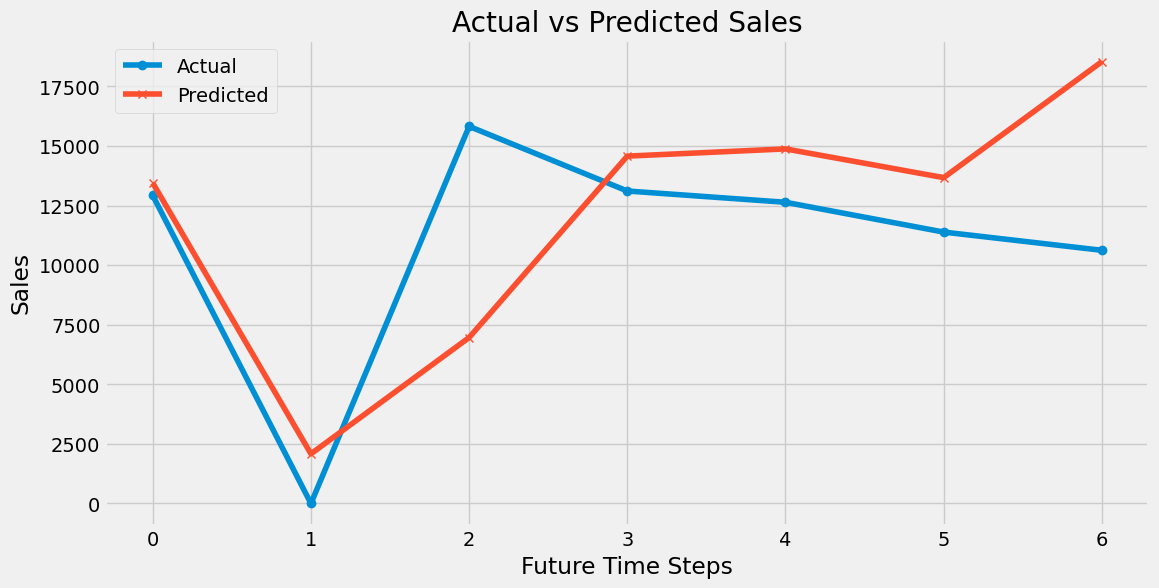

1/1 [==============================] - 0s 63ms/step


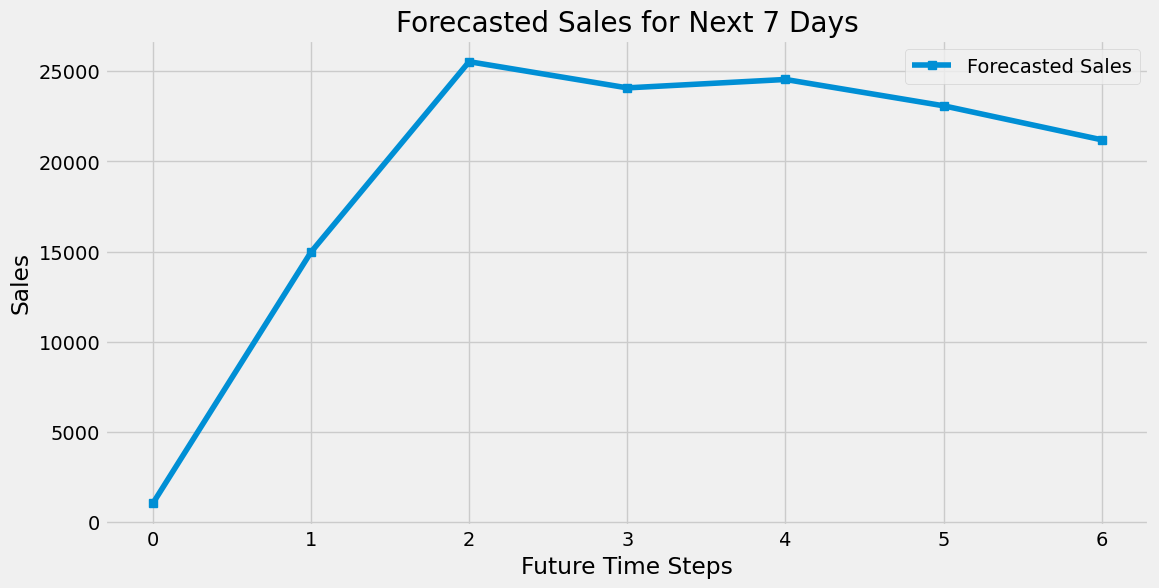

Look Back: 7, Split Ratio: 0.6-40.0, MAE: 3510.0950317454476, MSE: 22542999.60902107, RMSE: 4747.946883550939, R2: 0.6512409407638431
Epoch 1/50
288/288 [==============================] - 6s 5ms/step - loss: 0.0460
Epoch 2/50
288/288 [==============================] - 2s 5ms/step - loss: 0.0269
Epoch 3/50
288/288 [==============================] - 2s 5ms/step - loss: 0.0207
Epoch 4/50
288/288 [==============================] - 2s 5ms/step - loss: 0.0179
Epoch 5/50
288/288 [==============================] - 2s 5ms/step - loss: 0.0172
Epoch 6/50
288/288 [==============================] - 2s 6ms/step - loss: 0.0169
Epoch 7/50
288/288 [==============================] - 2s 6ms/step - loss: 0.0168
Epoch 8/50
288/288 [==============================] - 2s 6ms/step - loss: 0.0167
Epoch 9/50
288/288 [==============================] - 2s 6ms/step - loss: 0.0167
Epoch 10/50
288/288 [==============================] - 1s 5ms/step - loss: 0.0166
Epoch 11/50
288/288 [==============================] - 

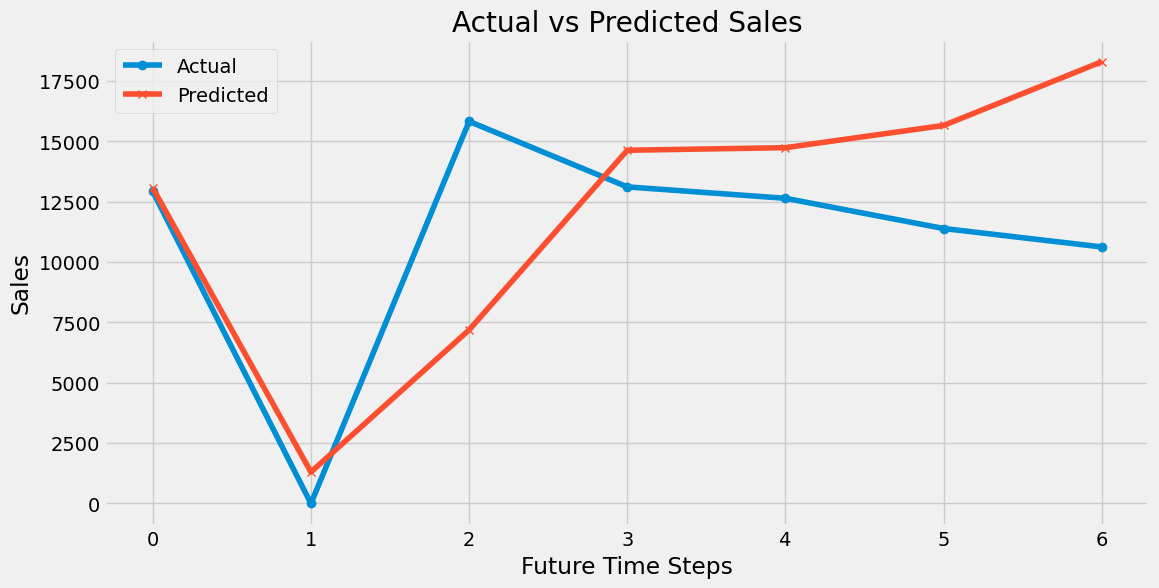

1/1 [==============================] - 0s 29ms/step


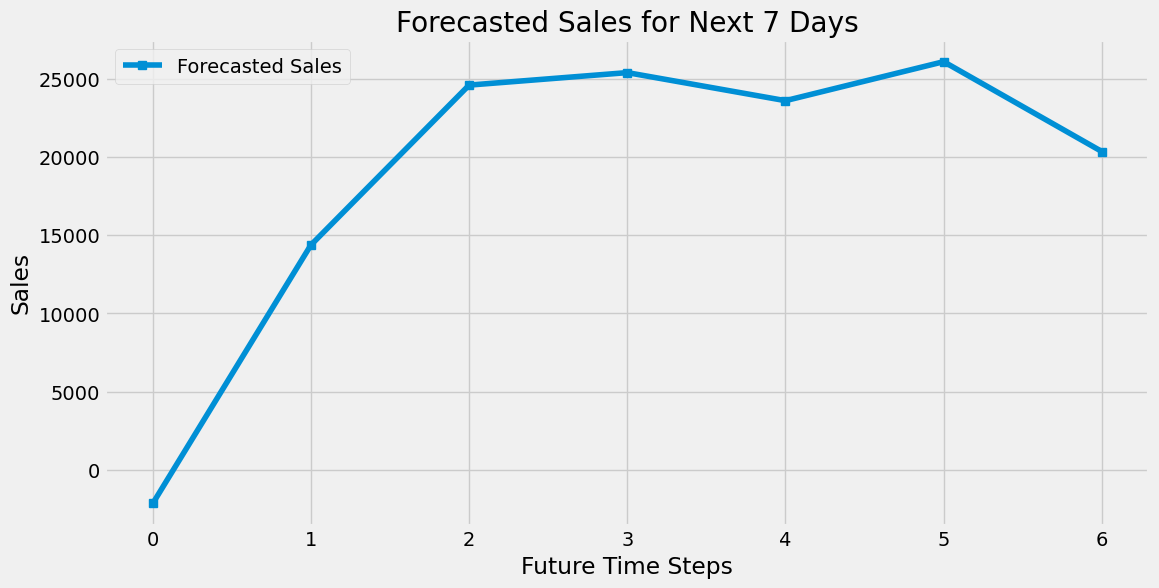

Look Back: 7, Split Ratio: 0.7-30.0, MAE: 3416.8905994156385, MSE: 21623426.642324854, RMSE: 4650.099637892166, R2: 0.6632902787303838
Epoch 1/50
288/288 [==============================] - 3s 3ms/step - loss: 0.0463
Epoch 2/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0260
Epoch 3/50
288/288 [==============================] - 1s 4ms/step - loss: 0.0203
Epoch 4/50
288/288 [==============================] - 1s 4ms/step - loss: 0.0180
Epoch 5/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0172
Epoch 6/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0171
Epoch 7/50
288/288 [==============================] - 1s 4ms/step - loss: 0.0169
Epoch 8/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0167
Epoch 9/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0166
Epoch 10/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0166
Epoch 11/50
288/288 [==============================] -

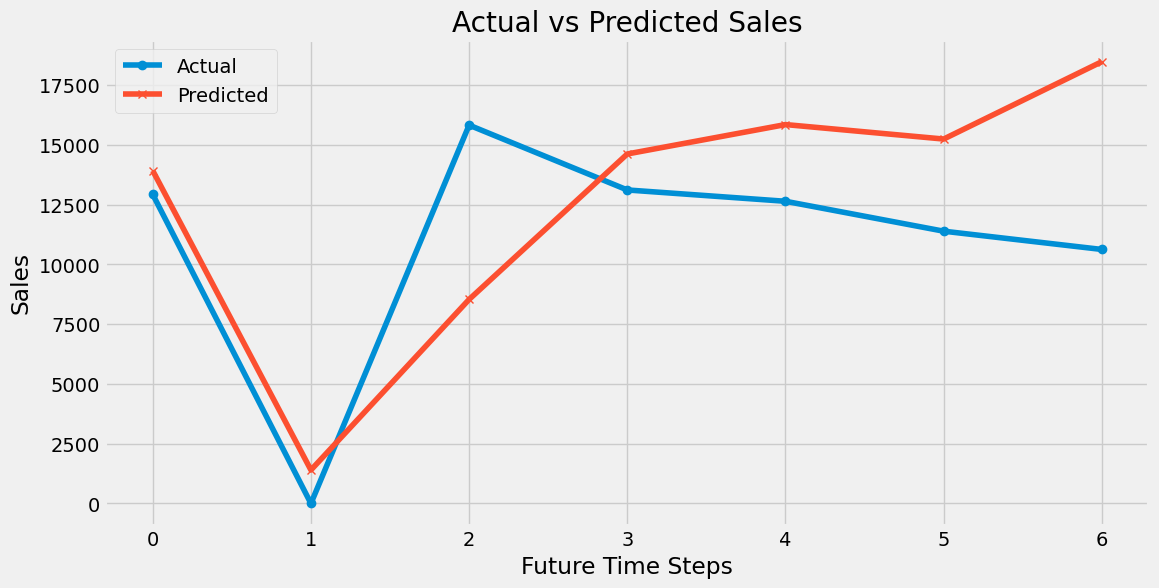

1/1 [==============================] - 0s 24ms/step


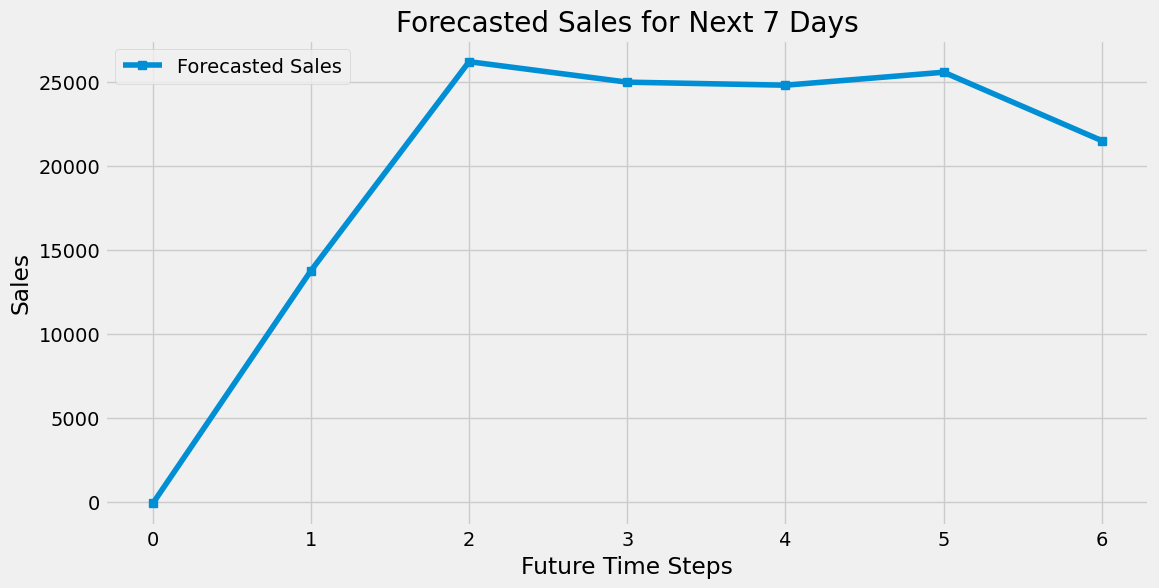

Look Back: 7, Split Ratio: 0.8-20.0, MAE: 3460.6193007174084, MSE: 21231678.454998296, RMSE: 4607.784549542035, R2: 0.672162098635902

Best Configuration:
{'look_back': 7, 'split_ratio': 0.3, 'MAE': 3416.8905994156385, 'MSE': 21623426.642324854, 'RMSE': 4650.099637892166, 'R2': 0.6632902787303838}


In [28]:
# Function to build and evaluate the model
def build_and_evaluate_model(look_back, split_ratio):
    # Feature Scaling
    scaler = MinMaxScaler()
    df_aggregated['Sales_scaled'] = scaler.fit_transform(df_aggregated[['Sales']])

    # Define look_forward
    look_forward = 7  # Number of future time steps to forecast

    # Data Sequencing
    X, Y = [], []
    for i in range(len(df_aggregated) - look_back - look_forward + 1):
        X.append(df_aggregated['Sales_scaled'][i:i+look_back].values)
        Y.append(df_aggregated['Sales_scaled'][i+look_back:i+look_back+look_forward].values)

    X, Y = np.array(X), np.array(Y)

    # Train-Test Split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Model Building
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(look_forward))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Model Training
    model.fit(X_train, Y_train, epochs=50, batch_size=1, verbose=1)

    # Prediction
    Y_pred = model.predict(X_test)

    # Inverse scaling
    Y_test_inv = scaler.inverse_transform(Y_test)
    Y_pred_inv = scaler.inverse_transform(Y_pred)

    # Evaluation
    mae = mean_absolute_error(Y_test_inv, Y_pred_inv)
    mse = mean_squared_error(Y_test_inv, Y_pred_inv)
    rmse = math.sqrt(mse)
    r2 = r2_score(Y_test_inv, Y_pred_inv)

    plt.figure(figsize=(12, 6))
    plt.plot(Y_test_inv[0], label='Actual', marker='o')
    plt.plot(Y_pred_inv[0], label='Predicted', marker='x')
    plt.title('Actual vs Predicted Sales')
    plt.ylabel('Sales')
    plt.xlabel('Future Time Steps')
    plt.legend()
    plt.show()

    # Forecasting future sales using last known sequence
    last_known_seq = X[-1:]
    last_known_seq = np.reshape(last_known_seq, (last_known_seq.shape[0], 1, last_known_seq.shape[1]))
    future_sales_scaled = model.predict(last_known_seq)
    future_sales = scaler.inverse_transform(future_sales_scaled)
    
    # Plotting the forecasted sales
    plt.figure(figsize=(12, 6))
    plt.plot(future_sales[0], label='Forecasted Sales', marker='s')
    plt.title('Forecasted Sales for Next ' + str(look_forward) + ' Days')
    plt.ylabel('Sales')
    plt.xlabel('Future Time Steps')
    plt.legend()
    plt.show()
    
    return mae, mse, rmse, r2

# Different scalers, look_backs, and split_ratios to try
look_backs = [7]
split_ratios = [0.4, 0.3, 0.2]

# To store the best results
best_mae = float('inf')
best_config = {}

# Loop through all combinations
for look_back in look_backs:
    for split_ratio in split_ratios:
        mae, mse, rmse, r2 = build_and_evaluate_model(look_back, split_ratio)
        print(f"Look Back: {look_back}, Split Ratio: {1 - split_ratio}-{split_ratio*100}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")
        
        if mae < best_mae:
            best_mae = mae
            best_config = {'look_back': look_back, 'split_ratio': split_ratio, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

print("\nBest Configuration:")
print(best_config)


## Random Forest, Linear Regression and Support Vector Regressor

In [29]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Define look_forward and look_back
look_forward = 7  # Number of future time steps to forecast

# Different algorithms to try
algorithms = {'LinearRegression': LinearRegression(), 
              'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
              'SVR': SVR()}

# Different look_backs and split_ratios to try
look_backs = [7]
split_ratios = [0.4, 0.3, 0.2]

# To store the best results
best_mae = float('inf')
best_config = {}

# Loop through all combinations
for algo_name, algo in algorithms.items():
    for look_back in look_backs:
        for split_ratio in split_ratios:
            # Data Sequencing
            X, Y = [], []
            for i in range(len(df_aggregated) - look_back - look_forward + 1):
                X.append(df_aggregated['Sales'][i:i+look_back].values)
                Y.append(df_aggregated['Sales'][i+look_back:i+look_back+look_forward].values)
            X, Y = np.array(X), np.array(Y)
            
            # Train-Test Split
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split_ratio, random_state=42)

            # Model Building and Training
            model = MultiOutputRegressor(algo)
            model.fit(X_train, Y_train)

            # Prediction
            Y_pred = model.predict(X_test)

            # Evaluation
            mae = mean_absolute_error(Y_test, Y_pred)
            r2 = r2_score(Y_test, Y_pred, multioutput='variance_weighted')
            
            print(f"Algorithm: {algo_name}, Look Back: {look_back}, Split Ratio: {1 - split_ratio}-{split_ratio*100}, MAE: {mae}, R2: {r2}")
            
            if mae < best_mae:
                best_mae = mae
                best_config = {'algorithm': algo_name, 'look_back': look_back, 'split_ratio': split_ratio, 'MAE': mae, 'R2': r2}

print("\nBest Configuration:")
print(best_config)


Algorithm: LinearRegression, Look Back: 7, Split Ratio: 0.6-40.0, MAE: 3799.845452498233, R2: 0.6173345220767437
Algorithm: LinearRegression, Look Back: 7, Split Ratio: 0.7-30.0, MAE: 3695.0012276394796, R2: 0.6608825477189053
Algorithm: LinearRegression, Look Back: 7, Split Ratio: 0.8-20.0, MAE: 3671.468769012211, R2: 0.626925823718123
Algorithm: RandomForest, Look Back: 7, Split Ratio: 0.6-40.0, MAE: 3391.605991214404, R2: 0.6665840348956924
Algorithm: RandomForest, Look Back: 7, Split Ratio: 0.7-30.0, MAE: 3302.985747110092, R2: 0.6992460810152449
Algorithm: RandomForest, Look Back: 7, Split Ratio: 0.8-20.0, MAE: 3198.006267301898, R2: 0.6890707434782124
Algorithm: SVR, Look Back: 7, Split Ratio: 0.6-40.0, MAE: 6361.826914540623, R2: -0.0007116599508042785
Algorithm: SVR, Look Back: 7, Split Ratio: 0.7-30.0, MAE: 6563.370042821871, R2: -0.005644543755528431
Algorithm: SVR, Look Back: 7, Split Ratio: 0.8-20.0, MAE: 6165.848333237963, R2: -0.00415191171026189

Best Configuration:
{'al

## CNN

Epoch 1/50
216/216 [==============================] - 1s 3ms/step - loss: 0.0373
Epoch 2/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0212
Epoch 3/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0174
Epoch 4/50
216/216 [==============================] - 1s 3ms/step - loss: 0.0158
Epoch 5/50
216/216 [==============================] - 1s 3ms/step - loss: 0.0149
Epoch 6/50
216/216 [==============================] - 1s 3ms/step - loss: 0.0144
Epoch 7/50
216/216 [==============================] - 1s 3ms/step - loss: 0.0141
Epoch 8/50
216/216 [==============================] - 1s 3ms/step - loss: 0.0142
Epoch 9/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 10/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0133
Epoch 11/50
216/216 [==============================] - 1s 3ms/step - loss: 0.0136
Epoch 12/50
216/216 [==============================] - 1s 3ms/step - loss: 0.0130
Epoch 13/50
216/216 [====

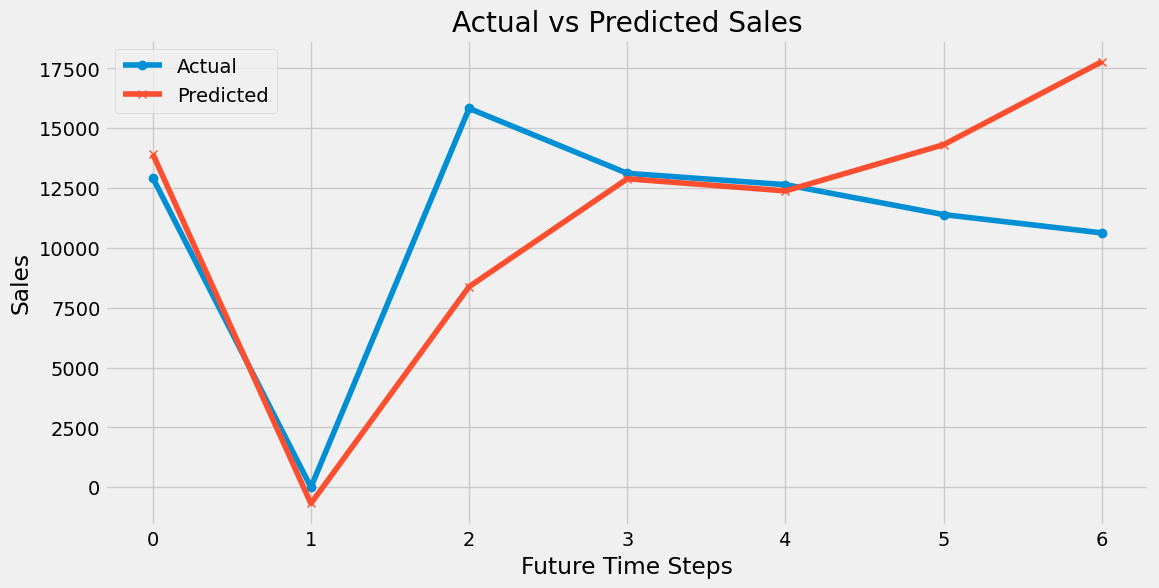

1/1 [==============================] - 0s 64ms/step


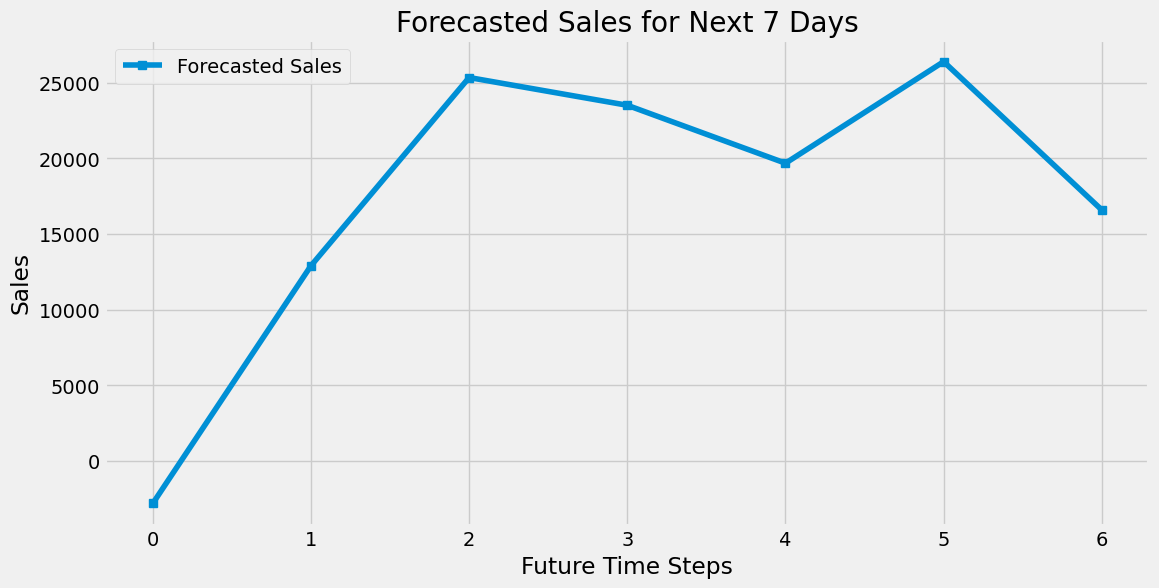

Look Back: 7, Split Ratio: 0.6-40.0, Metrics: {'MAE': 3369.8992761397044, 'MSE': 20326592.439583156, 'RMSE': 4508.50223905713, 'R2': 0.6960032349534064}
Epoch 1/50
252/252 [==============================] - 1s 2ms/step - loss: 0.0364
Epoch 2/50
252/252 [==============================] - 1s 2ms/step - loss: 0.0208
Epoch 3/50
252/252 [==============================] - 1s 4ms/step - loss: 0.0176
Epoch 4/50
252/252 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 5/50
252/252 [==============================] - 0s 1ms/step - loss: 0.0158
Epoch 6/50
252/252 [==============================] - 0s 1ms/step - loss: 0.0150
Epoch 7/50
252/252 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 8/50
252/252 [==============================] - 0s 1ms/step - loss: 0.0144
Epoch 9/50
252/252 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 10/50
252/252 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 11/50
252/252 [===============

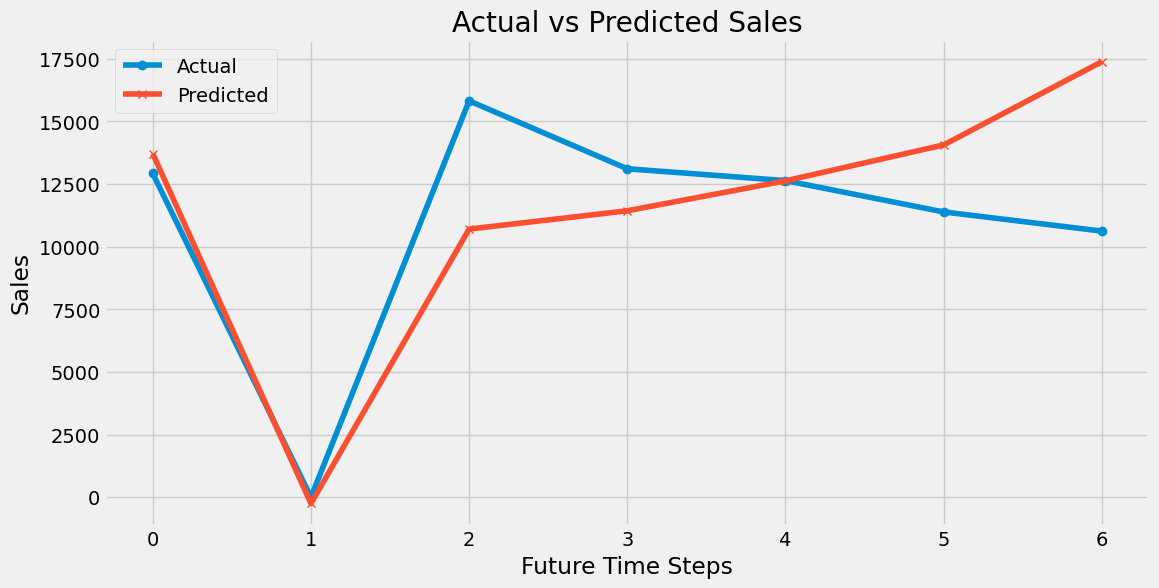

1/1 [==============================] - 0s 49ms/step


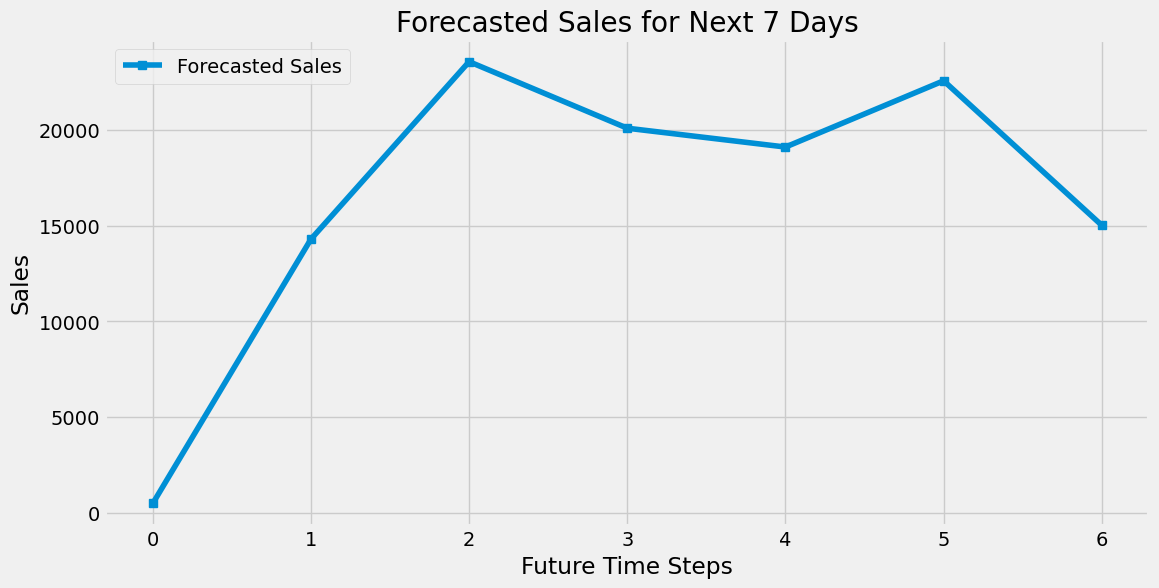

Look Back: 7, Split Ratio: 0.7-30.0, Metrics: {'MAE': 3483.1562011159, 'MSE': 20761214.18020439, 'RMSE': 4556.447539498769, 'R2': 0.7089228215757792}
Epoch 1/50
288/288 [==============================] - 1s 2ms/step - loss: 0.0366
Epoch 2/50
288/288 [==============================] - 0s 1ms/step - loss: 0.0199
Epoch 3/50
288/288 [==============================] - 0s 1ms/step - loss: 0.0172
Epoch 4/50
288/288 [==============================] - 0s 1ms/step - loss: 0.0159
Epoch 5/50
288/288 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 6/50
288/288 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 7/50
288/288 [==============================] - 0s 1ms/step - loss: 0.0144
Epoch 8/50
288/288 [==============================] - 0s 1ms/step - loss: 0.0143
Epoch 9/50
288/288 [==============================] - 0s 1ms/step - loss: 0.0139
Epoch 10/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0136
Epoch 11/50
288/288 [==================

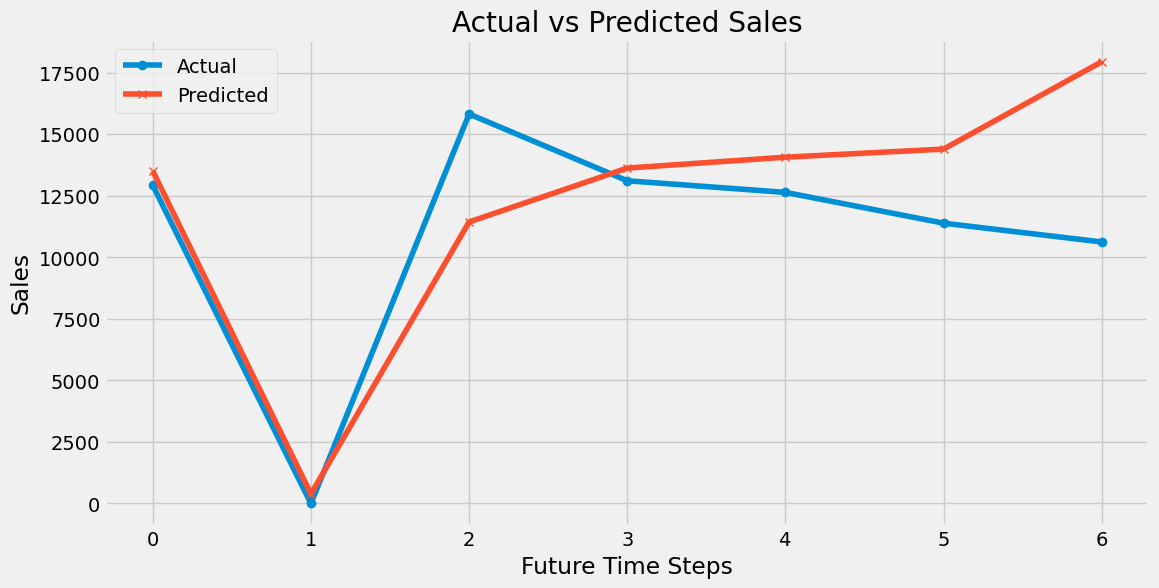

1/1 [==============================] - 0s 18ms/step


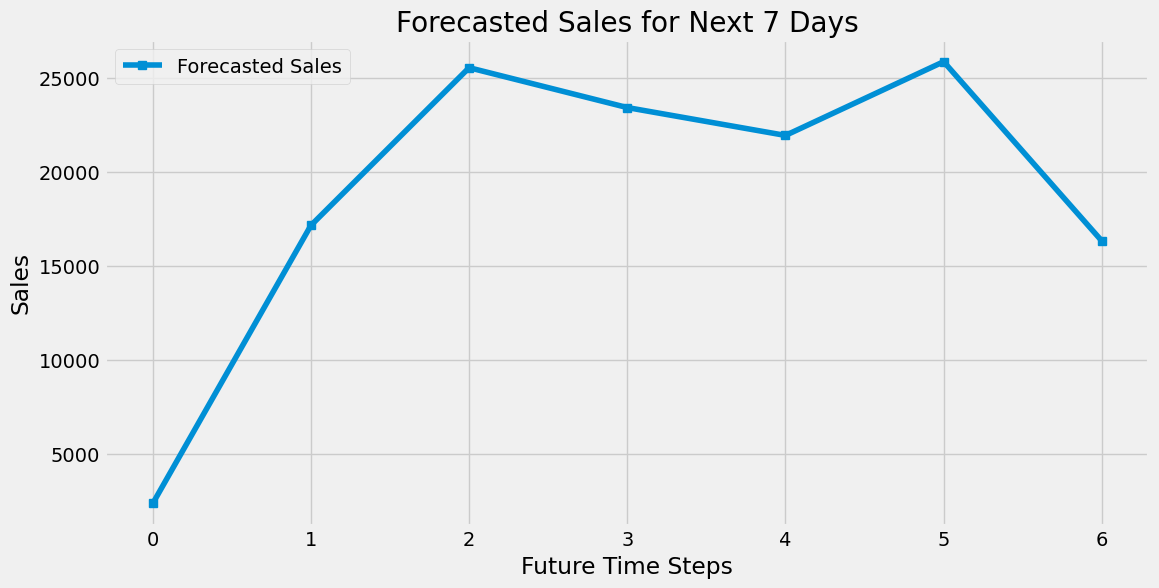

Look Back: 7, Split Ratio: 0.8-20.0, Metrics: {'MAE': 3156.2785535081684, 'MSE': 18712088.678622786, 'RMSE': 4325.747181542489, 'R2': 0.7066993477190548}

Best Configuration and Metrics:
Configuration: {'look_back': 7, 'split_ratio': 0.2}
Metrics: {'MAE': 3156.2785535081684, 'MSE': 18712088.678622786, 'RMSE': 4325.747181542489, 'R2': 0.7066993477190548}


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np
import math

def build_and_evaluate_cnn_model(df_aggregated, look_back, split_ratio):
    # Feature Scaling
    scaler = MinMaxScaler()
    df_aggregated['Sales_scaled'] = scaler.fit_transform(df_aggregated[['Sales']])
    
    # Define look_forward
    look_forward = 7  # Number of future time steps to forecast
    
    # Data Sequencing
    X, Y = [], []
    for i in range(len(df_aggregated) - look_back - look_forward + 1):
        X.append(df_aggregated['Sales_scaled'][i:i+look_back].values)
        Y.append(df_aggregated['Sales_scaled'][i+look_back:i+look_back+look_forward].values)
    
    X, Y = np.array(X), np.array(Y)
    
    # Train-Test Split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split_ratio, random_state=42)
    
    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Model Building
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(look_forward))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Model Training
    model.fit(X_train, Y_train, epochs=50, batch_size=1, verbose=1)
    
    # Prediction
    Y_pred = model.predict(X_test)
    
    # Inverse scaling
    Y_test_inv = scaler.inverse_transform(Y_test)
    Y_pred_inv = scaler.inverse_transform(Y_pred)
    
    # Evaluation
    metrics = {}
    metrics['MAE'] = mean_absolute_error(Y_test_inv, Y_pred_inv)
    metrics['MSE'] = mean_squared_error(Y_test_inv, Y_pred_inv)
    metrics['RMSE'] = math.sqrt(metrics['MSE'])
    metrics['R2'] = r2_score(Y_test_inv, Y_pred_inv)
    
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test_inv[0], label='Actual', marker='o')
    plt.plot(Y_pred_inv[0], label='Predicted', marker='x')
    plt.title('Actual vs Predicted Sales')
    plt.ylabel('Sales')
    plt.xlabel('Future Time Steps')
    plt.legend()
    plt.show()

    # Debugging
    last_known_seq = X[-1:]
    
    last_known_seq = np.reshape(last_known_seq, (last_known_seq.shape[0], last_known_seq.shape[1], 1))
    
    future_sales_scaled = model.predict(last_known_seq)
    future_sales = scaler.inverse_transform(future_sales_scaled)
    
    # Plotting the forecasted sales
    plt.figure(figsize=(12, 6))
    plt.plot(future_sales[0], label='Forecasted Sales', marker='s')
    plt.title('Forecasted Sales for Next ' + str(look_forward) + ' Days')
    plt.ylabel('Sales')
    plt.xlabel('Future Time Steps')
    plt.legend()
    plt.show()
    
    return metrics


# Different split_ratios to try
look_backs = [7]
split_ratios = [0.4, 0.3, 0.2]

# To store the best results
best_metrics = {'MAE': float('inf'), 'MSE': float('inf'), 'RMSE': float('inf'), 'R2': float('-inf')}
best_config = {}

# Loop through all combinations
for look_back in look_backs:
    for split_ratio in split_ratios:
        metrics = build_and_evaluate_cnn_model(df_aggregated, look_back, split_ratio)
        
        print(f"Look Back: {look_back}, Split Ratio: {1 - split_ratio}-{split_ratio*100}, Metrics: {metrics}")
        
        if metrics['MAE'] < best_metrics['MAE'] and metrics['MSE'] < best_metrics['MSE'] and metrics['R2'] > best_metrics['R2']:
            best_metrics = metrics
            best_config = {'look_back': look_back, 'split_ratio': split_ratio}

print("\nBest Configuration and Metrics:")
print("Configuration:", best_config)
print("Metrics:", best_metrics)


## CNN and Random Forest (Hybrid)

In [31]:
# Importing necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np
import math

# Sample function to build and evaluate a hybrid CNN-Random Forest model
def build_and_evaluate_hybrid_model(look_back, split_ratio):
    # Feature Scaling
    scaler = MinMaxScaler()
    df_aggregated['Sales_scaled'] = scaler.fit_transform(df_aggregated[['Sales']])
    
    # Define look_forward
    look_forward = 7  # Number of future time steps to forecast
    
    # Data Sequencing
    X, Y = [], []
    for i in range(len(df_aggregated) - look_back - look_forward + 1):
        X.append(df_aggregated['Sales_scaled'][i:i+look_back].values)
        Y.append(df_aggregated['Sales_scaled'][i+look_back:i+look_back+look_forward].values)
    
    X, Y = np.array(X), np.array(Y)
    
    # Train-Test Split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split_ratio, random_state=42)
    
    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # CNN Model Building
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(50, activation='relu'))
    cnn_model.add(Dense(look_forward))  # This should match with 'look_forward'
    cnn_model.compile(optimizer='adam', loss='mean_squared_error')
    
    # CNN Model Training
    cnn_model.fit(X_train, Y_train, epochs=50, batch_size=1, verbose=1)
    
    # Feature extraction with CNN
    feature_model = Sequential(cnn_model.layers[:-1])
    X_train_transformed = feature_model.predict(X_train)
    X_test_transformed = feature_model.predict(X_test)
    
    # Random Forest Model Building
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_transformed, Y_train)
    
    # Prediction with Random Forest
    Y_pred = rf_model.predict(X_test_transformed)
    
    # Inverse scaling
    Y_test_inv = scaler.inverse_transform(Y_test)
    Y_pred_inv = scaler.inverse_transform(Y_pred)
    
    # Evaluation
    metrics = {}
    metrics['MAE'] = mean_absolute_error(Y_test_inv, Y_pred_inv)
    metrics['MSE'] = mean_squared_error(Y_test_inv, Y_pred_inv)
    metrics['RMSE'] = math.sqrt(metrics['MSE'])
    metrics['R2'] = r2_score(Y_test_inv, Y_pred_inv)
    
    return metrics

# Different split_ratios to try
look_backs = [7]
split_ratios = [0.4, 0.3, 0.2]

# To store the best results
best_metrics = {'MAE': float('inf'), 'MSE': float('inf'), 'RMSE': float('inf'), 'R2': float('-inf')}
best_config = {}

# Loop through all combinations
for look_back in look_backs:
    for split_ratio in split_ratios:
        metrics = build_and_evaluate_hybrid_model(look_back, split_ratio)
        
        print(f"Look Back: {look_back}, Split Ratio: {1 - split_ratio}-{split_ratio*100}, Metrics: {metrics}")
        
        # Update best metrics and configuration if needed
        if metrics['MAE'] < best_metrics['MAE'] and metrics['MSE'] < best_metrics['MSE'] and metrics['R2'] > best_metrics['R2']:
            best_metrics = metrics
            best_config = {'look_back': look_back, 'split_ratio': split_ratio}

print("\nBest Configuration and Metrics:")
print("Configuration:", best_config)
print("Metrics:", best_metrics)


Epoch 1/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0393
Epoch 2/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 3/50
216/216 [==============================] - 0s 1ms/step - loss: 0.0177
Epoch 4/50
216/216 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 5/50
216/216 [==============================] - 0s 1ms/step - loss: 0.0156
Epoch 6/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 7/50
216/216 [==============================] - 0s 1ms/step - loss: 0.0145
Epoch 8/50
216/216 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 9/50
216/216 [==============================] - 0s 1ms/step - loss: 0.0143
Epoch 10/50
216/216 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 11/50
216/216 [==============================] - 0s 1ms/step - loss: 0.0136
Epoch 12/50
216/216 [==============================] - 0s 1ms/step - loss: 0.0136
Epoch 13/50
216/216 [====

## LSTM and Random Forest (Hybrid)

In [32]:
# Importing necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import math

# Sample function to build and evaluate a hybrid LSTM-Random Forest model
def build_and_evaluate_hybrid_model(look_back, split_ratio):
    # Feature Scaling
    scaler = MinMaxScaler()
    df_aggregated['Sales_scaled'] = scaler.fit_transform(df_aggregated[['Sales']])
    
    # Define look_forward
    look_forward = 7  # Number of future time steps to forecast
    
    # Data Sequencing
    X, Y = [], []
    for i in range(len(df_aggregated) - look_back - look_forward + 1):
        X.append(df_aggregated['Sales_scaled'][i:i+look_back].values)
        Y.append(df_aggregated['Sales_scaled'][i+look_back:i+look_back+look_forward].values)
    
    X, Y = np.array(X), np.array(Y)
    
    # Train-Test Split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split_ratio, random_state=42)
    
    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # LSTM Model Building
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    lstm_model.add(Dense(look_forward))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    
    # LSTM Model Training
    lstm_model.fit(X_train, Y_train, epochs=50, batch_size=1, verbose=1)
    
    # Feature extraction with LSTM
    feature_model = Sequential(lstm_model.layers[:-1])
    X_train_transformed = feature_model.predict(X_train)
    X_test_transformed = feature_model.predict(X_test)
    
    # Random Forest Model Building
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_transformed, Y_train)
    
    # Prediction with Random Forest
    Y_pred = rf_model.predict(X_test_transformed)
    
    # Inverse scaling
    Y_test_inv = scaler.inverse_transform(Y_test)
    Y_pred_inv = scaler.inverse_transform(Y_pred)
    
    # Evaluation
    metrics = {}
    metrics['MAE'] = mean_absolute_error(Y_test_inv, Y_pred_inv)
    metrics['MSE'] = mean_squared_error(Y_test_inv, Y_pred_inv)
    metrics['RMSE'] = math.sqrt(metrics['MSE'])
    metrics['R2'] = r2_score(Y_test_inv, Y_pred_inv)
    
    return metrics

# Different split_ratios to try
look_backs = [7]
split_ratios = [0.4, 0.3, 0.2]

# To store the best results
best_metrics = {'MAE': float('inf'), 'MSE': float('inf'), 'RMSE': float('inf'), 'R2': float('-inf')}
best_config = {}

# Loop through all combinations
for look_back in look_backs:
    for split_ratio in split_ratios:
        metrics = build_and_evaluate_hybrid_model(look_back, split_ratio)
        
        print(f"Look Back: {look_back}, Split Ratio: {1 - split_ratio}-{split_ratio*100}, Metrics: {metrics}")
        
        # Update best metrics and configuration if needed
        if metrics['MAE'] < best_metrics['MAE'] and metrics['MSE'] < best_metrics['MSE'] and metrics['R2'] > best_metrics['R2']:
            best_metrics = metrics
            best_config = {'look_back': look_back, 'split_ratio': split_ratio}

print("\nBest Configuration and Metrics:")
print("Configuration:", best_config)
print("Metrics:", best_metrics)


Epoch 1/50
216/216 [==============================] - 3s 5ms/step - loss: 0.0450
Epoch 2/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0337
Epoch 3/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0315
Epoch 4/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0288
Epoch 5/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0269
Epoch 6/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0247
Epoch 7/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0237
Epoch 8/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0229
Epoch 9/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0226
Epoch 10/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0217
Epoch 11/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0211
Epoch 12/50
216/216 [==============================] - 1s 6ms/step - loss: 0.0203
Epoch 13/50
216/216 [====

## Gated Recurrent Unit

Epoch 1/50
216/216 [==============================] - 2s 4ms/step - loss: 0.0515
Epoch 2/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0341
Epoch 3/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0318
Epoch 4/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0294
Epoch 5/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0277
Epoch 6/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0261
Epoch 7/50
216/216 [==============================] - 1s 4ms/step - loss: 0.0252
Epoch 8/50
216/216 [==============================] - 1s 5ms/step - loss: 0.0242
Epoch 9/50
216/216 [==============================] - 1s 4ms/step - loss: 0.0229
Epoch 10/50
216/216 [==============================] - 1s 4ms/step - loss: 0.0224
Epoch 11/50
216/216 [==============================] - 1s 4ms/step - loss: 0.0219
Epoch 12/50
216/216 [==============================] - 1s 4ms/step - loss: 0.0209
Epoch 13/50
216/216 [====

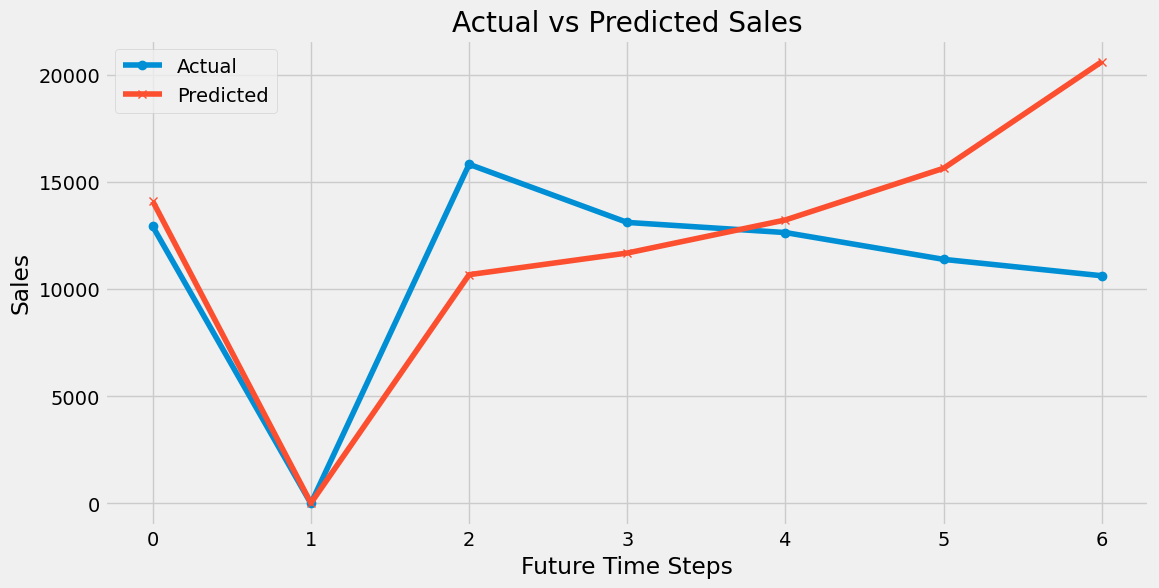

1/1 [==============================] - 0s 114ms/step


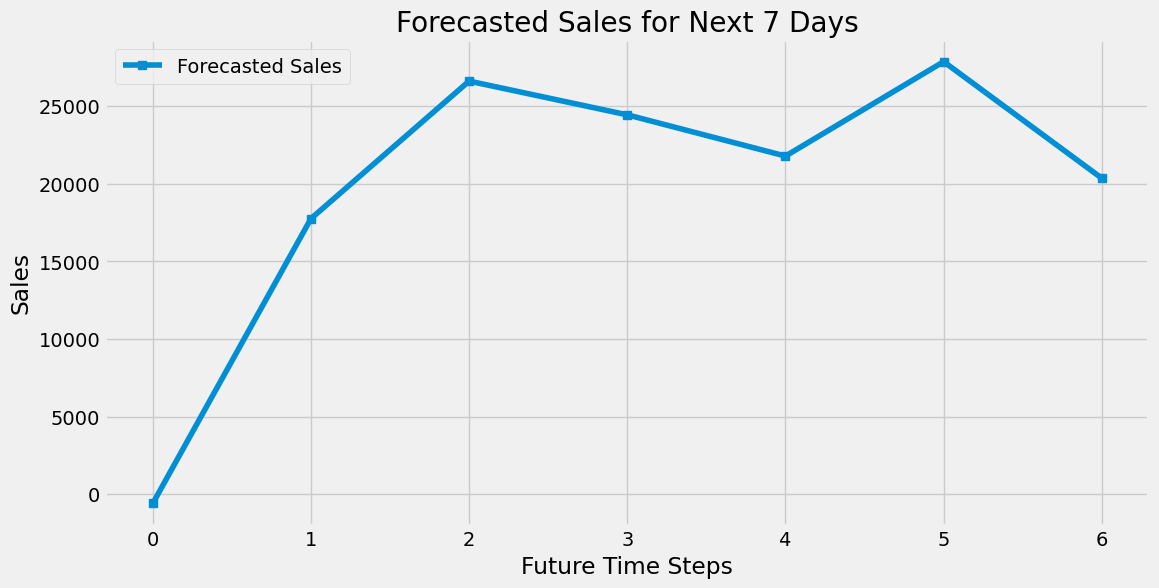

Look Back: 7, Split Ratio: 0.4, Metrics: {'MAE': 3147.2194899100214, 'MSE': 18472517.528488, 'RMSE': 4297.966673729335, 'R2': 0.7226290542875898}
Epoch 1/50
252/252 [==============================] - 4s 5ms/step - loss: 0.0527
Epoch 2/50
252/252 [==============================] - 2s 8ms/step - loss: 0.0345
Epoch 3/50
252/252 [==============================] - 2s 8ms/step - loss: 0.0298
Epoch 4/50
252/252 [==============================] - 2s 8ms/step - loss: 0.0263
Epoch 5/50
252/252 [==============================] - 2s 8ms/step - loss: 0.0251
Epoch 6/50
252/252 [==============================] - 2s 7ms/step - loss: 0.0239
Epoch 7/50
252/252 [==============================] - 2s 7ms/step - loss: 0.0231
Epoch 8/50
252/252 [==============================] - 1s 6ms/step - loss: 0.0228
Epoch 9/50
252/252 [==============================] - 2s 6ms/step - loss: 0.0222
Epoch 10/50
252/252 [==============================] - 2s 6ms/step - loss: 0.0215
Epoch 11/50
252/252 [======================

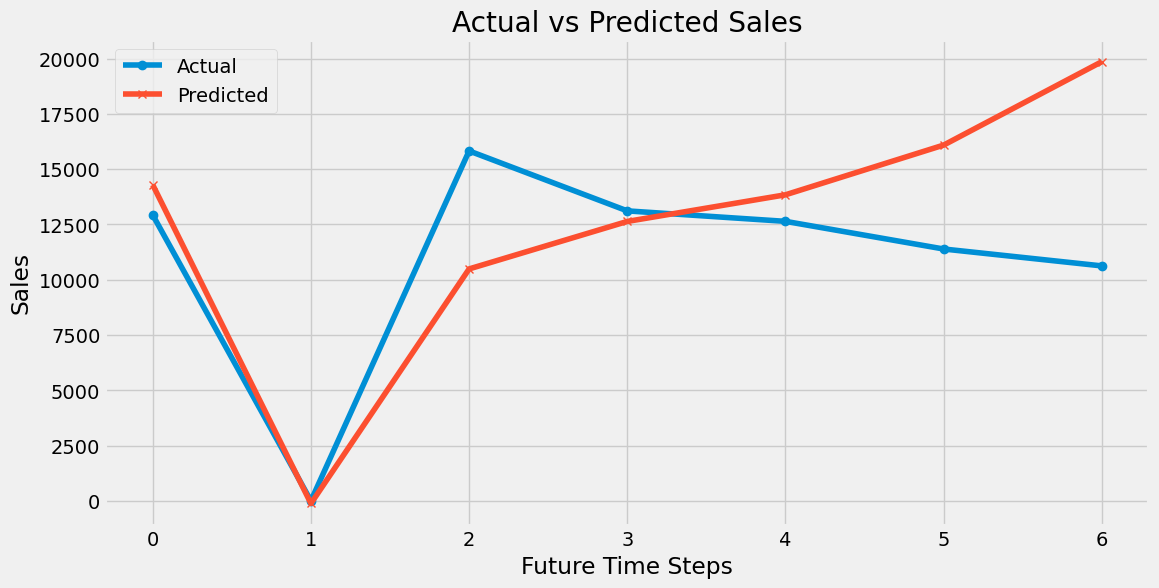

1/1 [==============================] - 0s 24ms/step


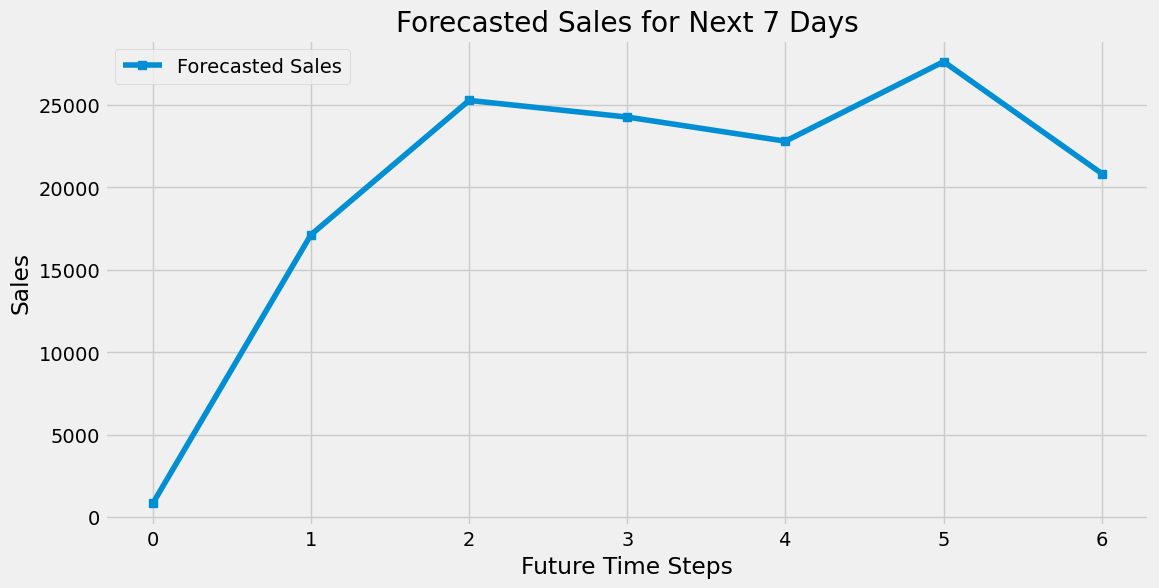

Look Back: 7, Split Ratio: 0.3, Metrics: {'MAE': 3036.416955931318, 'MSE': 17052962.634496994, 'RMSE': 4129.52329385572, 'R2': 0.7596530368082289}
Epoch 1/50
288/288 [==============================] - 2s 3ms/step - loss: 0.0465
Epoch 2/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0332
Epoch 3/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0305
Epoch 4/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0277
Epoch 5/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0257
Epoch 6/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0248
Epoch 7/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0239
Epoch 8/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0232
Epoch 9/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0223
Epoch 10/50
288/288 [==============================] - 1s 3ms/step - loss: 0.0215
Epoch 11/50
288/288 [=====================

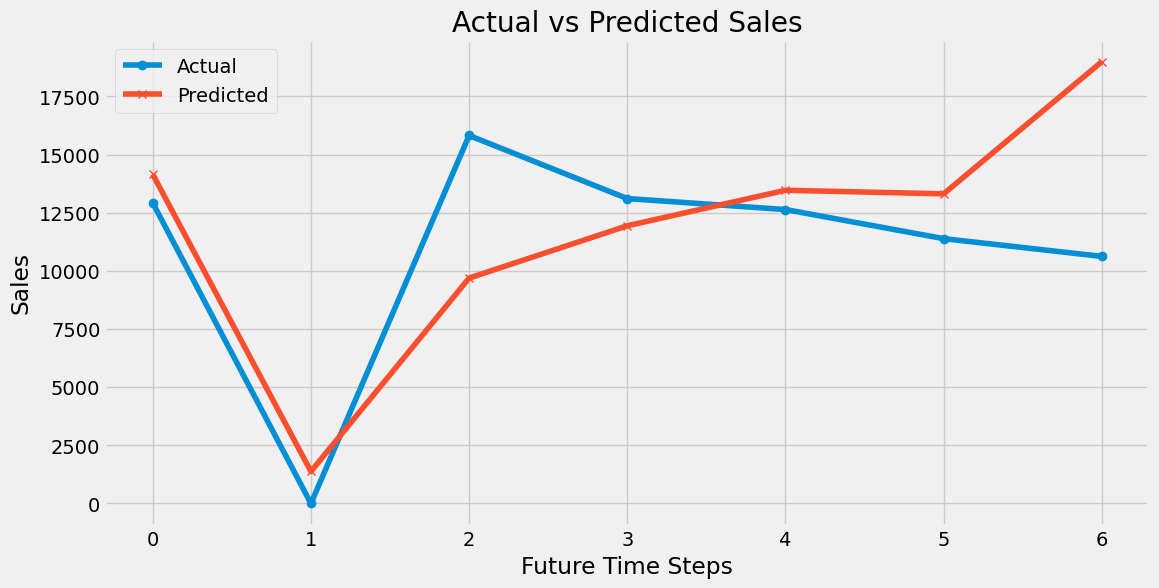

1/1 [==============================] - 0s 70ms/step


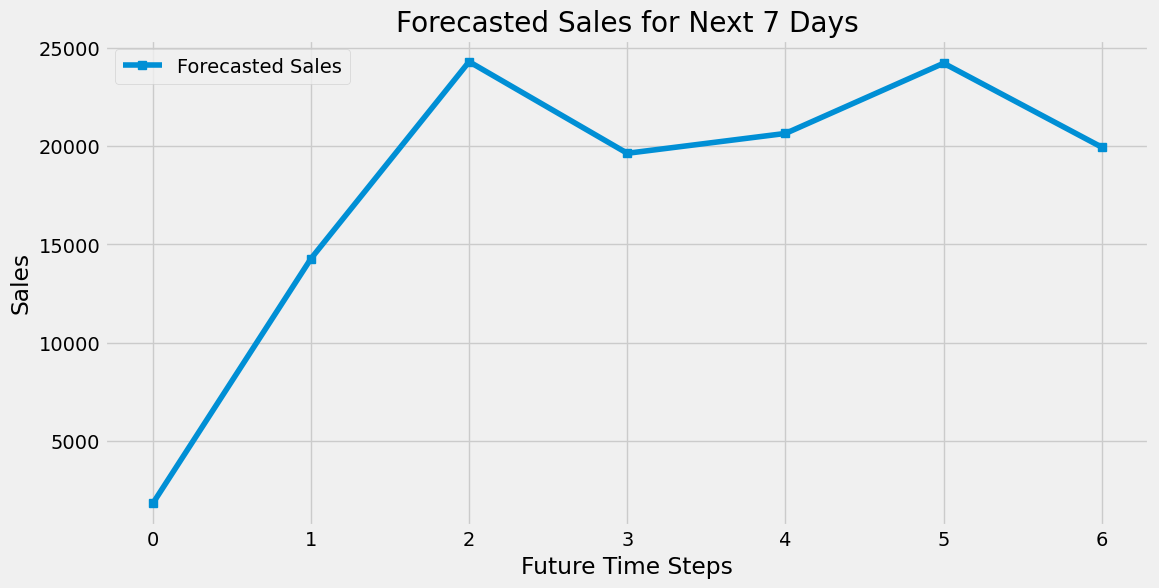

Look Back: 7, Split Ratio: 0.2, Metrics: {'MAE': 2970.7886544064636, 'MSE': 16735261.873746723, 'RMSE': 4090.875440996306, 'R2': 0.7429012321426967}

Best Configuration and Metrics:
Configuration: {'look_back': 7, 'split_ratio': 0.3}
Metrics: {'MAE': 3036.416955931318, 'MSE': 17052962.634496994, 'RMSE': 4129.52329385572, 'R2': 0.7596530368082289}


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import numpy as np
import matplotlib.pyplot as plt
import math

def build_and_evaluate_gru_model(df_aggregated, look_back, split_ratio):
    # Feature Scaling
    scaler = MinMaxScaler()
    df_aggregated['Sales_scaled'] = scaler.fit_transform(df_aggregated[['Sales']])
    
    # Define look_forward
    look_forward = 7
    
    # Data Sequencing
    X, Y = [], []
    for i in range(len(df_aggregated) - look_back - look_forward + 1):
        X.append(df_aggregated['Sales_scaled'][i:i+look_back])
        Y.append(df_aggregated['Sales_scaled'][i+look_back:i+look_back+look_forward])
        
    X, Y = np.array(X), np.array(Y)
    
    # Train-Test Split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split_ratio, random_state=42)
    
    # Reshape input
    X_train = X_train.reshape((X_train.shape[0], look_back, 1))
    X_test = X_test.reshape((X_test.shape[0], look_back, 1))
    
    # Build GRU model
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(look_forward))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, Y_train, epochs=50, batch_size=1, verbose=1)
    
    # Predict
    Y_pred = model.predict(X_test)
    
    # Inverse transform
    Y_pred_inv = scaler.inverse_transform(Y_pred)
    Y_test_inv = scaler.inverse_transform(Y_test)
    
    # Evaluate
    metrics = {
        'MAE': mean_absolute_error(Y_test_inv, Y_pred_inv),
        'MSE': mean_squared_error(Y_test_inv, Y_pred_inv),
        'RMSE': math.sqrt(mean_squared_error(Y_test_inv, Y_pred_inv)),
        'R2': r2_score(Y_test_inv, Y_pred_inv)
    }
    
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test_inv[0], label='Actual', marker='o')
    plt.plot(Y_pred_inv[0], label='Predicted', marker='x')
    plt.title('Actual vs Predicted Sales')
    plt.ylabel('Sales')
    plt.xlabel('Future Time Steps')
    plt.legend()
    plt.show()

    # Debugging
    last_known_seq = X[-1:]
    
    last_known_seq = np.reshape(last_known_seq, (last_known_seq.shape[0], last_known_seq.shape[1], 1))
    
    future_sales_scaled = model.predict(last_known_seq)
    future_sales = scaler.inverse_transform(future_sales_scaled)
    
    # Plotting the forecasted sales
    plt.figure(figsize=(12, 6))
    plt.plot(future_sales[0], label='Forecasted Sales', marker='s')
    plt.title('Forecasted Sales for Next ' + str(look_forward) + ' Days')
    plt.ylabel('Sales')
    plt.xlabel('Future Time Steps')
    plt.legend()
    plt.show()
    
    
    return metrics

look_backs = [7]
split_ratios = [0.4, 0.3, 0.2]

best_metrics = {'MAE': float('inf'), 'MSE': float('inf'), 'RMSE': float('inf'), 'R2': -1}

for look_back in look_backs:
    for split_ratio in split_ratios:
        metrics = build_and_evaluate_gru_model(df_aggregated, look_back, split_ratio)
        print(f"Look Back: {look_back}, Split Ratio: {split_ratio}, Metrics: {metrics}")
        
        if metrics['R2'] > best_metrics['R2']:
            best_metrics = metrics
            best_config = {'look_back': look_back, 'split_ratio': split_ratio}

print("\nBest Configuration and Metrics:")
print("Configuration:", best_config)
print("Metrics:", best_metrics)
